<a href="https://colab.research.google.com/github/Faiz-Hibatullah/machine-learning-1103210172/blob/main/8.%20Week%208%20UTS/Clustering_Models_UTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install memory_profiler

In [1]:
# Import libraries
import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.cluster.hierarchy import dendrogram
from matplotlib import cm
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold, mutual_info_regression, chi2, f_classif
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, silhouette_samples
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from memory_profiler import memory_usage
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.utils import resample
from joblib import Parallel, delayed
import warnings
import time

# Set aesthetic parameters for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)
warnings.filterwarnings('ignore')

## 1. Mengmabil dan Membersihkan Data

Downloading...
From: https://drive.google.com/uc?export=download&id=1HIJVXKQwABrxDVoKj3eMTCmQ7T8LinF8
To: /content/dataset.csv
100%|██████████| 45.6M/45.6M [00:00<00:00, 63.4MB/s]


Dataset Shape: (541909, 8)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB

Summary Statistics:

Missing Values Analysis:
             Missing Values  Percent Missing
Description            1454         0.268311
CustomerID           135080        24.926694


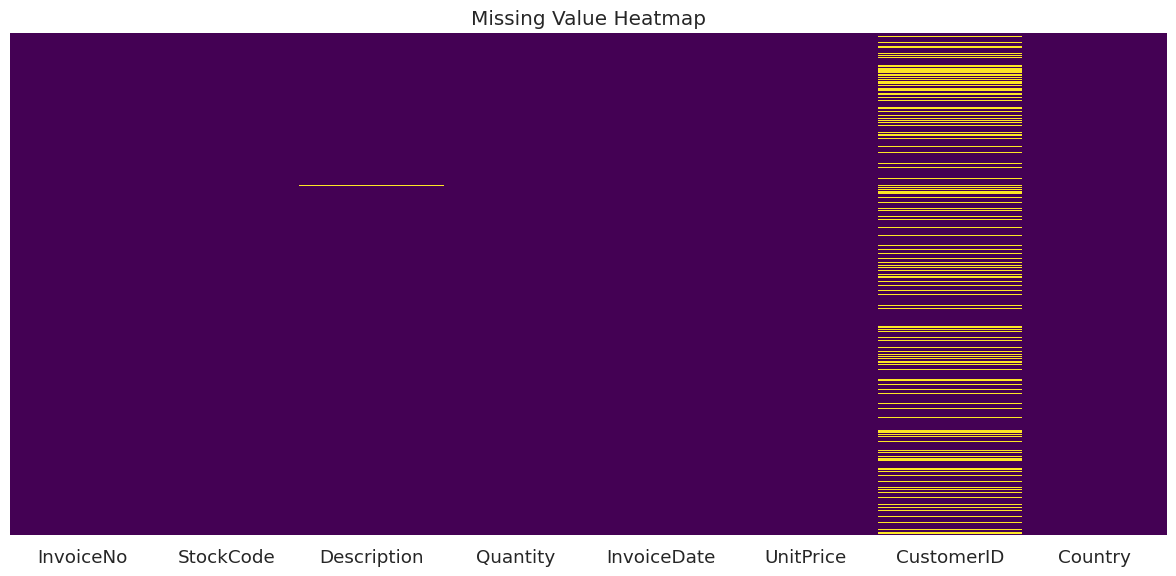


Outlier Detection (IQR method):
Quantity: 58619 outliers detected (10.82%)
UnitPrice: 39627 outliers detected (7.31%)

Verifying Data Cleaning:
Missing values after imputation: 0
Outliers after capping: 0

Data Cleaning Summary:
- Original dataset shape: (541909, 8)
- Missing values handled with imputation
- Outliers capped using IQR method
- Final dataset shape: (541909, 8)


In [2]:
"""
## 1. Data Acquisition & Cleaning
In this section, we'll download the dataset, load it using Pandas, and clean it by handling missing values and outliers.
"""

# Download the dataset from Google Drive
file_id = '1HIJVXKQwABrxDVoKj3eMTCmQ7T8LinF8'
url = f'https://drive.google.com/uc?export=download&id={file_id}'
output = 'dataset.csv'
gdown.download(url, output, quiet=False)

# Load the dataset
df = pd.read_csv('dataset.csv', encoding='latin1')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

print("\nSummary Statistics:")
df.describe().T

# Check for missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values,
                           'Percent Missing': missing_percent})
print("\nMissing Values Analysis:")
print(missing_df[missing_df['Missing Values'] > 0])

# Visualize missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Value Heatmap')
plt.tight_layout()
plt.show()

# Function to detect outliers using IQR method
def detect_outliers_iqr(df, column):
    """
    Detect outliers in a column using the Interquartile Range (IQR) method.

    Parameters:
    df (DataFrame): Input dataframe
    column (str): Column name to check for outliers

    Returns:
    list: Indices of outlier rows
    """
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
    return outliers

# Identify numeric columns for outlier detection
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Detect outliers in numeric columns
outliers_by_column = {}
for col in numeric_columns:
    outliers = detect_outliers_iqr(df, col)
    if len(outliers) > 0:
        outliers_by_column[col] = len(outliers)

print("\nOutlier Detection (IQR method):")
for col, count in outliers_by_column.items():
    print(f"{col}: {count} outliers detected ({count/len(df)*100:.2f}%)")

# # Visualize distributions of numeric features to inspect for anomalies
# plt.figure(figsize=(20, 15))
# for i, col in enumerate(numeric_columns[:min(16, len(numeric_columns))]):
#     plt.subplot(4, 4, i+1)
#     sns.histplot(df[col], kde=True)
#     plt.title(f'Distribution of {col}')
# plt.tight_layout()
# plt.show()

# Data cleaning strategy

# 1. Handle missing values
# For numeric columns, impute with median (robust to outliers)
numeric_imputer = SimpleImputer(strategy='median')
df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])

# For categorical columns (if any)
categorical_columns = df.select_dtypes(include=['object']).columns
if len(categorical_columns) > 0:
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

# 2. Handle outliers
# Option 1: Cap outliers at the upper and lower bounds
for col in numeric_columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # Cap the outliers
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

# Verify data cleaning results
print("\nVerifying Data Cleaning:")
print("Missing values after imputation:", df.isnull().sum().sum())

# Function to detect outliers after capping
def count_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
    return len(outliers)

outliers_after = {col: count_outliers_iqr(df, col) for col in numeric_columns}
print("Outliers after capping:", sum(outliers_after.values()))

# Summary of data cleaning process
print("\nData Cleaning Summary:")
print(f"- Original dataset shape: {df.shape}")
print(f"- Missing values handled with imputation")
print(f"- Outliers capped using IQR method")
print(f"- Final dataset shape: {df.shape}")


## 2. Feature Selection

Low variance features (threshold=0.01): []
Dataset shape after removing low variance features: (541909, 8)
Duplicate groups found: []
Will drop: []


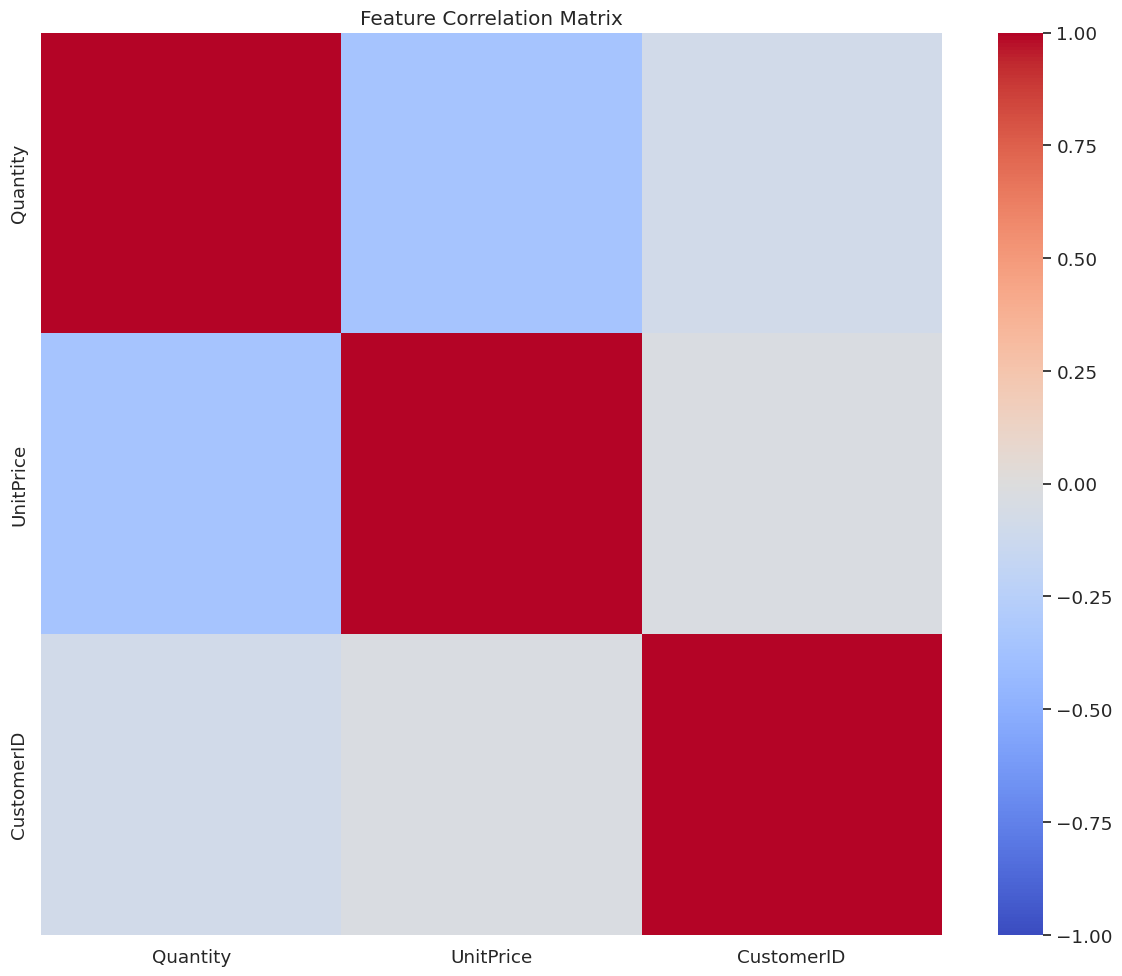


Highly correlated feature pairs (|r| > 0.80):

Features dropped due to high correlation: []
Dataset shape after correlation-based feature selection: (541909, 8)

Feature Selection Summary:
- Original number of features: 8
- Low variance features removed: 0
- Duplicate features removed: 0
- Highly correlated features removed: 0
- Final number of features: 8


In [3]:
"""
## 2. Feature Selection
In this section, we'll select the most relevant features for clustering by:
1. Removing constant and quasi-constant features
2. Checking for collinearity
3. Using mutual information for feature relevance (if target is available)
"""

# Remove constant and quasi-constant features
# Features with variance close to zero don't add much information
def remove_low_variance_features(df, threshold=0.01):
    """
    Remove features with variance below the threshold.

    Parameters:
    df (DataFrame): Input dataframe
    threshold (float): Threshold for variance

    Returns:
    DataFrame: DataFrame with low variance features removed
    list: Names of removed features
    """
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(df[numeric_columns])

    # Get feature names that passed the variance threshold
    constant_features = [numeric_columns[i] for i in range(len(numeric_columns))
                        if not selector.get_support()[i]]

    print(f"Low variance features (threshold={threshold}):", constant_features)

    # Remove constant features
    if constant_features:
        df_filtered = df.drop(columns=constant_features)
        return df_filtered, constant_features
    else:
        return df, []

df_filtered, removed_features = remove_low_variance_features(df)
print(f"Dataset shape after removing low variance features: {df_filtered.shape}")

# Check for duplicate features
def find_duplicate_columns(df, hash_func=pd.util.hash_pandas_object):
    """
    Identify groups of duplicate columns using hashing.

    Returns:
        duplicate_groups: List of tuples (col1, col2, ...)
    """
    # Step 1: Compute a hash for each column series (ignoring the index)
    col_hashes = {}
    for col in df.columns:
        # This returns a Series of hashed row‐values; sum to get a single fingerprint
        fingerprint = int(hash_func(df[col], index=False).sum())
        col_hashes.setdefault(fingerprint, []).append(col)

    # Step 2: Within each hash‐bucket, optionally verify and then collect actual duplicates
    duplicate_groups = []
    for bucket in col_hashes.values():
        if len(bucket) > 1:
            # Optional verification to guard against collisions:
            verified = []
            used = set()
            for i, col_i in enumerate(bucket):
                if col_i in used:
                    continue
                group = [col_i]
                for col_j in bucket[i+1:]:
                    if col_j in used:
                        continue
                    if np.array_equal(df[col_i].values, df[col_j].values):
                        group.append(col_j)
                        used.add(col_j)
                if len(group) > 1:
                    verified.append(tuple(group))
            duplicate_groups.extend(verified)

    return duplicate_groups

# Example usage:
duplicate_groups = find_duplicate_columns(df_filtered)
print("Duplicate groups found:", duplicate_groups)

duplicate_columns = [
    dup for group in duplicate_groups for dup in group[1:]
]
print("Will drop:", duplicate_columns)

# Remove duplicate features
if duplicate_columns:
    df_filtered = df_filtered.drop(columns=duplicate_columns)
    print(f"Dataset shape after removing duplicate features: {df_filtered.shape}")

# Compute correlation matrix for numeric features
correlation_matrix = df_filtered.select_dtypes(include=['int64', 'float64']).corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Identify highly correlated feature pairs
def identify_correlated_features(correlation_matrix, threshold=0.80):
    """
    Identify pairs of features with correlation above the threshold.

    Parameters:
    correlation_matrix (DataFrame): Correlation matrix
    threshold (float): Correlation threshold

    Returns:
    list: Pairs of highly correlated features with their correlation value
    """
    correlated_features = []

    # Get the upper triangle of the correlation matrix
    upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than threshold
    for col in upper_tri.columns:
        high_corr = upper_tri[col][abs(upper_tri[col]) > threshold].index.tolist()
        for feature in high_corr:
            correlated_features.append((col, feature, correlation_matrix.loc[col, feature]))

    return correlated_features

# Identify pairs of features with high correlation
correlated_features = identify_correlated_features(correlation_matrix, threshold=0.80)
print("\nHighly correlated feature pairs (|r| > 0.80):")
for feat1, feat2, corr in correlated_features:
    print(f"{feat1} and {feat2}: r = {corr:.3f}")

# Feature selection based on correlation
def select_features_from_correlated_pairs(df, correlated_features):
    """
    Select which features to keep from highly correlated pairs.
    Strategy: For each pair, keep the one with higher average correlation with other features.

    Parameters:
    df (DataFrame): Input dataframe
    correlated_features (list): List of correlated feature pairs

    Returns:
    DataFrame: DataFrame with selected features
    list: Features to drop
    """
    if not correlated_features:
        return df, []

    # Create a set of all features involved in high correlation
    all_correlated_features = set()
    for feat1, feat2, _ in correlated_features:
        all_correlated_features.add(feat1)
        all_correlated_features.add(feat2)

    # Calculate the mean absolute correlation for each feature
    corr_matrix = df[list(all_correlated_features)].corr()
    mean_abs_corr = {}
    for feature in all_correlated_features:
        # Exclude self-correlation (which is always 1)
        mean_abs_corr[feature] = corr_matrix[feature].abs().mean()

    # Decide which features to drop
    features_to_drop = set()
    for feat1, feat2, _ in correlated_features:
        # Keep the feature with higher mean absolute correlation
        if mean_abs_corr[feat1] > mean_abs_corr[feat2]:
            features_to_drop.add(feat2)
        else:
            features_to_drop.add(feat1)

    # Drop the selected features
    if features_to_drop:
        df_selected = df.drop(columns=list(features_to_drop))
        return df_selected, list(features_to_drop)
    else:
        return df, []

# Select features based on correlation analysis
df_selected, dropped_correlated = select_features_from_correlated_pairs(df_filtered, correlated_features)
print(f"\nFeatures dropped due to high correlation: {dropped_correlated}")
print(f"Dataset shape after correlation-based feature selection: {df_selected.shape}")

# If there's a target variable, calculate mutual information
# Note: For unsupervised clustering, there might not be a target variable
# We'll check if we can infer if any column might be a potential target

# For this example, we'll assume there's no target variable
# If there was a target, we would use:
# numeric_features = df_selected.select_dtypes(include=['int64', 'float64']).columns.tolist()
# target = 'target_column_name'
# mi_scores = mutual_info_regression(df_selected[numeric_features], df_selected[target])
# mi_df = pd.DataFrame({'Feature': numeric_features, 'MI Score': mi_scores})
# mi_df = mi_df.sort_values('MI Score', ascending=False)
# print("Mutual Information Scores:")
# print(mi_df)

# Summary of feature selection process
print("\nFeature Selection Summary:")
print(f"- Original number of features: {df.shape[1]}")
print(f"- Low variance features removed: {len(removed_features)}")
print(f"- Duplicate features removed: {len(duplicate_columns)}")
print(f"- Highly correlated features removed: {len(dropped_correlated)}")
print(f"- Final number of features: {df_selected.shape[1]}")

# Update the numeric_columns variable for the remaining features
numeric_columns = df_selected.select_dtypes(include=['int64', 'float64']).columns.tolist()

## 3. Feature Engineering


Skewness of numeric features:
Quantity      1.203269
UnitPrice     1.114452
CustomerID    0.102463
dtype: float64


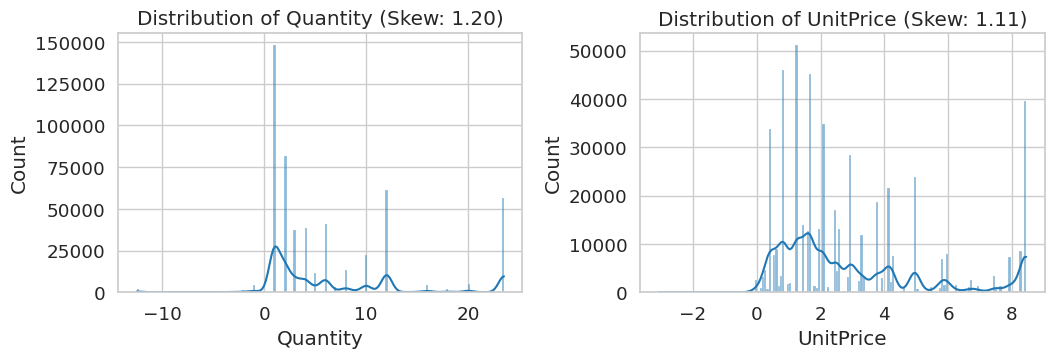


Transformed features:
- Quantity -> Quantity_log
- UnitPrice -> UnitPrice_log


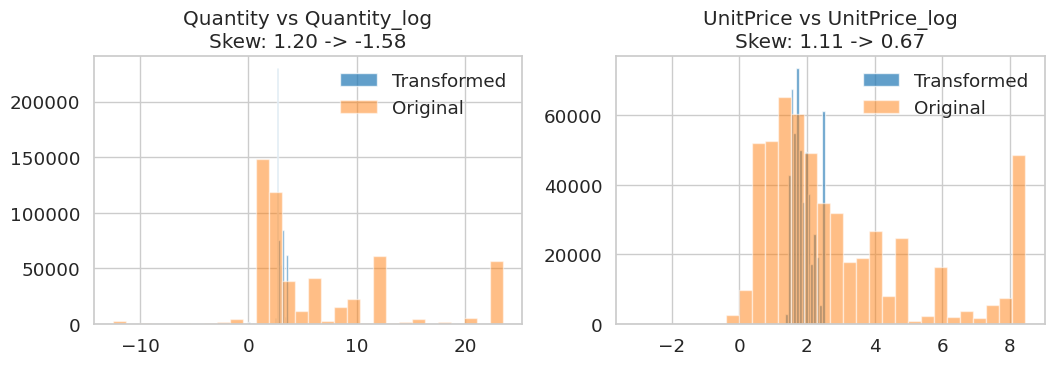

Keeping original version of Quantity (transformation didn't significantly reduce skewness)
Keeping original version of UnitPrice (transformation didn't significantly reduce skewness)


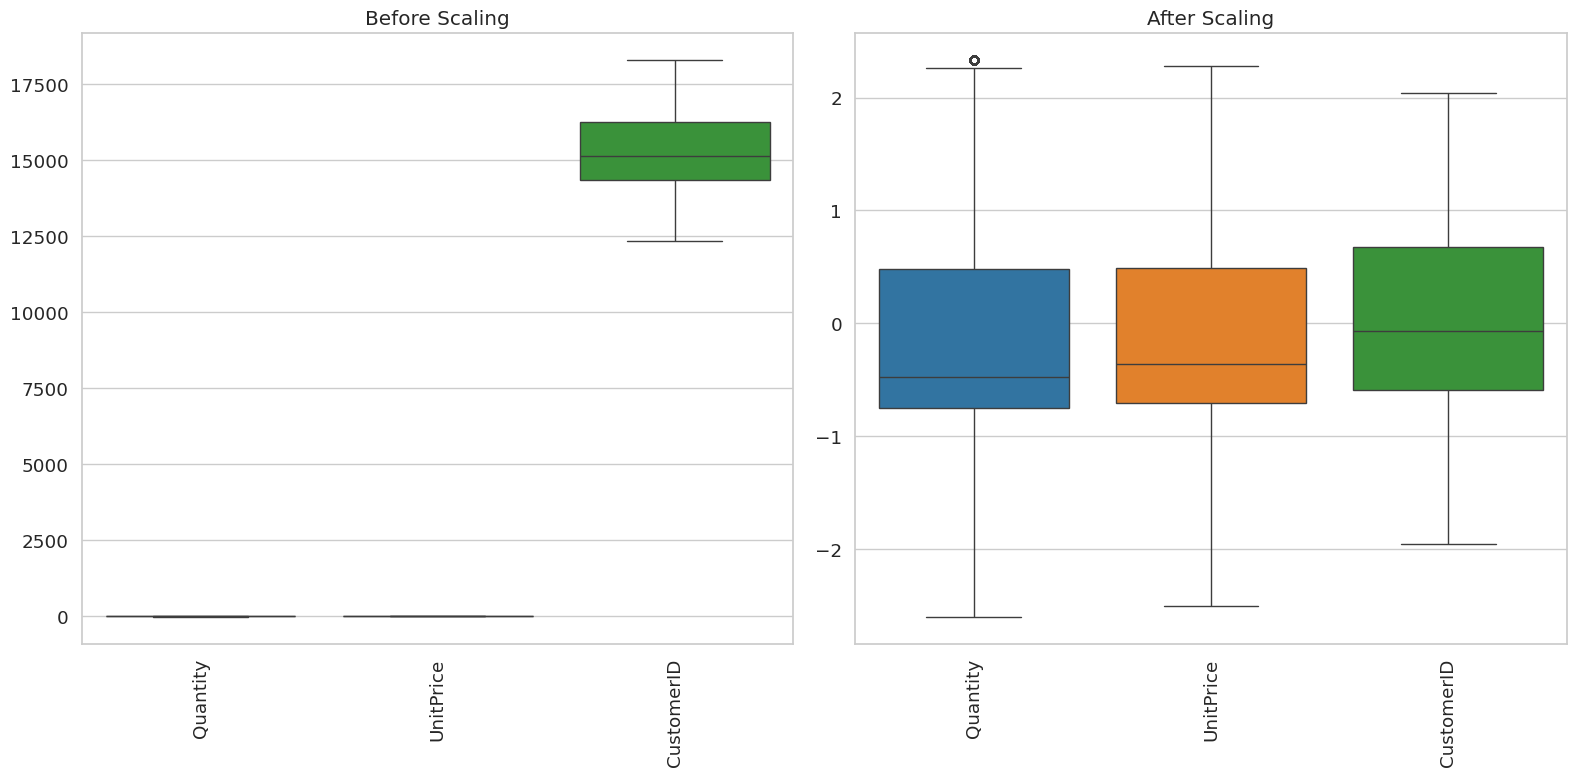

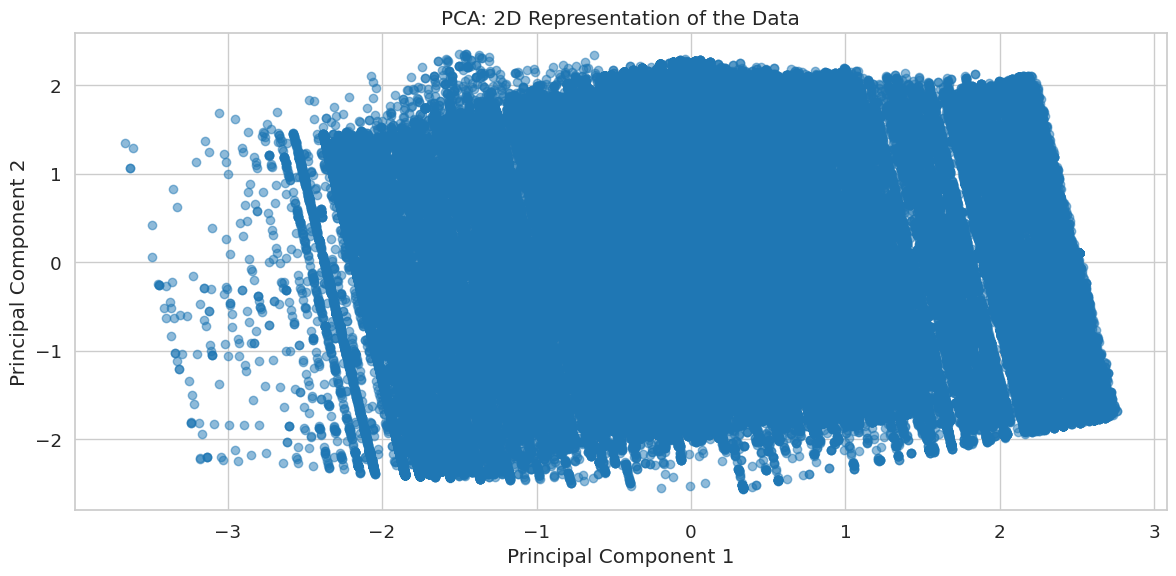


Feature Engineering Summary:
- Skewed features transformed: 2
- Scaling method: Standard Scaling
- Final dataset shape: (541909, 8)


In [4]:
"""
## 3. Feature Engineering
In this section, we'll transform features to improve clustering performance:
1. Handle skewed features
2. Scale the features
3. Create polynomial features or interactions if needed
"""

# Check the skewness of the features
skewness = df_selected[numeric_columns].apply(lambda x: stats.skew(x))
print("\nSkewness of numeric features:")
print(skewness.sort_values(ascending=False))

# Visualize the distribution of the most skewed features
plt.figure(figsize=(16, 10))
highly_skewed = skewness[abs(skewness) > 1].index.tolist()
if highly_skewed:
    for i, col in enumerate(highly_skewed[:min(9, len(highly_skewed))]):
        plt.subplot(3, 3, i+1)
        sns.histplot(df_selected[col], kde=True)
        plt.title(f'Distribution of {col} (Skew: {skewness[col]:.2f})')
    plt.tight_layout()
    plt.show()
else:
    print("No highly skewed features found.")

# Apply transformations to skewed features
def transform_skewed_features(df, skewness, threshold=1.0):
    """
    Transform skewed features using appropriate methods.

    Parameters:
    df (DataFrame): Input dataframe
    skewness (Series): Series containing skewness values for each feature
    threshold (float): Skewness threshold for transformation

    Returns:
    DataFrame: DataFrame with transformed features
    dict: Dictionary mapping original feature names to their transformed versions
    """
    df_transformed = df.copy()
    transformed_features = {}

    for col, skew_val in skewness.items():
        if abs(skew_val) > threshold:
            # For positive skew, apply log or power transformation
            if skew_val > 0:
                # Check if the feature has non-positive values
                if df[col].min() <= 0:
                    # Shift the values to be all positive
                    shift = abs(df[col].min()) + 1
                    df_transformed[f"{col}_log"] = np.log(df[col] + shift)
                    transformed_features[col] = f"{col}_log"
                else:
                    df_transformed[f"{col}_log"] = np.log(df[col])
                    transformed_features[col] = f"{col}_log"
            # For negative skew, other transformations might be appropriate
            else:
                # Square transformation can help with negative skew
                df_transformed[f"{col}_squared"] = df[col] ** 2
                transformed_features[col] = f"{col}_squared"

    return df_transformed, transformed_features

# Transform skewed features
df_transformed, transformed_features = transform_skewed_features(df_selected, skewness)
print("\nTransformed features:")
for original, transformed in transformed_features.items():
    print(f"- {original} -> {transformed}")

# Check the skewness after transformation
if transformed_features:
    transformed_cols = list(transformed_features.values())
    new_skewness = df_transformed[transformed_cols].apply(lambda x: stats.skew(x))

    plt.figure(figsize=(16, 10))
    for i, (orig, trans) in enumerate(transformed_features.items()):
        if i >= 9:
            break
        plt.subplot(3, 3, i+1)
        plt.hist(df_transformed[trans], bins=30, alpha=0.7, label='Transformed')
        plt.hist(df_selected[orig], bins=30, alpha=0.5, label='Original')
        plt.title(f'{orig} vs {trans}\nSkew: {skewness[orig]:.2f} -> {new_skewness[trans]:.2f}')
        plt.legend()
    plt.tight_layout()
    plt.show()

# Decide whether to keep the original or transformed features
# For clustering, we'll usually want to keep only one version to avoid duplication
# Here we'll keep the transformed version if it reduced the absolute skewness
def select_best_transformation(df_original, df_transformed, original_skewness, transformed_features):
    """
    Select the best transformation for each feature based on skewness reduction.

    Parameters:
    df_original (DataFrame): Original dataframe
    df_transformed (DataFrame): Dataframe with transformed features
    original_skewness (Series): Original skewness values
    transformed_features (dict): Dictionary mapping original features to transformed ones

    Returns:
    DataFrame: Dataframe with the best version of each feature
    """
    df_selected = df_original.copy()

    # Calculate skewness for the transformed features
    transformed_cols = list(transformed_features.values())
    if transformed_cols:
        new_skewness = df_transformed[transformed_cols].apply(lambda x: stats.skew(x))

        # Compare original and transformed skewness
        for orig, trans in transformed_features.items():
            # If the transformation reduced the absolute skewness by at least 50%
            if abs(new_skewness[trans]) < abs(original_skewness[orig]) * 0.5:
                # Replace the original with the transformed
                df_selected[orig] = df_transformed[trans]
                print(f"Keeping transformed version of {orig} (skew: {original_skewness[orig]:.2f} -> {new_skewness[trans]:.2f})")
            else:
                print(f"Keeping original version of {orig} (transformation didn't significantly reduce skewness)")

    return df_selected

# Select the best version of each feature
df_selected = select_best_transformation(df_selected, df_transformed, skewness, transformed_features)

# Feature scaling
# For clustering, scaling is crucial to ensure all features contribute equally
def scale_features(df, method='standard'):
    """
    Scale the features using the specified method.

    Parameters:
    df (DataFrame): Input dataframe
    method (str): Scaling method ('standard', 'minmax', or 'power')

    Returns:
    DataFrame: Dataframe with scaled features
    object: Scaler object for future transformations
    """
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
    df_scaled = df.copy()

    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    elif method == 'power':
        scaler = PowerTransformer(method='yeo-johnson')
    else:
        raise ValueError("Invalid scaling method. Choose 'standard', 'minmax', or 'power'.")

    # Fit the scaler and transform the data
    df_scaled[numeric_features] = scaler.fit_transform(df[numeric_features])

    return df_scaled, scaler

# Scale the features using standardization
df_scaled, scaler = scale_features(df_selected, method='standard')

# Visualize the effect of scaling
plt.figure(figsize=(16, 8))
# Original data distribution (first 5 features)
plt.subplot(1, 2, 1)
sns.boxplot(data=df_selected[numeric_columns[:5]])
plt.title('Before Scaling')
plt.xticks(rotation=90)
# Scaled data distribution
plt.subplot(1, 2, 2)
sns.boxplot(data=df_scaled[numeric_columns[:5]])
plt.title('After Scaling')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Create polynomial features if needed
# For clustering, polynomial features are generally not as useful as for supervised learning
# However, they can capture non-linear relationships in the data
def create_polynomial_features(df, degree=2, interaction_only=True):
    """
    Create polynomial features from the original features.

    Parameters:
    df (DataFrame): Input dataframe
    degree (int): Degree of the polynomial features
    interaction_only (bool): Whether to include only interaction terms

    Returns:
    DataFrame: Dataframe with added polynomial features
    """
    from sklearn.preprocessing import PolynomialFeatures

    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns

    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, interaction_only=interaction_only, include_bias=False)
    poly_features = poly.fit_transform(df[numeric_features])

    # Get the names of the polynomial features
    feature_names = poly.get_feature_names_out(numeric_features)

    # Create a dataframe with the polynomial features
    poly_df = pd.DataFrame(poly_features, columns=feature_names)

    # Remove the original features to avoid duplication
    poly_df = poly_df.drop(columns=numeric_features)

    # Combine the original dataframe with the polynomial features
    df_poly = pd.concat([df.reset_index(drop=True), poly_df.reset_index(drop=True)], axis=1)

    return df_poly

# For this example, we'll skip polynomial features unless it's deemed necessary
# Uncomment this if needed:
# df_poly = create_polynomial_features(df_scaled, degree=2, interaction_only=True)
# print(f"Dataset shape after adding polynomial features: {df_poly.shape}")

# Dimensionality reduction for visualization
# Reduce to 2D for visualization purposes
def reduce_dimensions(df, method='pca', n_components=2):
    """
    Reduce dimensionality of the data for visualization.

    Parameters:
    df (DataFrame): Input dataframe
    method (str): Dimensionality reduction method ('pca' or 'tsne')
    n_components (int): Number of components to keep

    Returns:
    array: Reduced data
    object: Dimensionality reduction model
    """
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns

    if method == 'pca':
        reducer = PCA(n_components=n_components, random_state=42)
    elif method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42, perplexity=30, n_jobs=-1)
    else:
        raise ValueError("Invalid method. Choose 'pca' or 'tsne'.")

    # Fit and transform the data
    reduced_data = reducer.fit_transform(df[numeric_features])

    return reduced_data, reducer

# Reduce dimensions for visualization
data_2d_pca, pca_model = reduce_dimensions(df_scaled, method='pca', n_components=2)
#data_2d_tsne, tsne_model = reduce_dimensions(df_scaled, method='tsne', n_components=2)

# Visualize the 2D representation
plt.figure(figsize=(12, 6))
plt.scatter(data_2d_pca[:, 0], data_2d_pca[:, 1], alpha=0.5)
plt.title('PCA: 2D Representation of the Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature engineering summary
print("\nFeature Engineering Summary:")
print(f"- Skewed features transformed: {len(transformed_features)}")
print(f"- Scaling method: Standard Scaling")
#print(f"- Polynomial features added: {df_poly.shape[1] - df_scaled.shape[1]}")
print(f"- Final dataset shape: {df_scaled.shape}")


## 4. Clustering Models

In [5]:
"""
## 4. Clustering Models
In this section, we'll implement and compare five clustering algorithms:
1. KMeans
2. AgglomerativeClustering
3. DBSCAN
4. GaussianMixture
5. SpectralClustering
"""

# Prepare data for clustering
X = df_scaled.select_dtypes(include=['int64', 'float64'])

# Create a helper function for silhouette visualization
def plot_silhouette(X, cluster_labels, n_clusters, max_points_per_cluster=5000,
                    silhouette_sample_size=10000, random_state=42):
    """
    Plot silhouette analysis for clustering results optimized for large datasets.

    Parameters:
    X (array): Input data
    cluster_labels (array): Cluster labels for each data point
    n_clusters (int): Number of clusters
    max_points_per_cluster (int): Maximum number of points to display per cluster
    silhouette_sample_size (int): Maximum number of samples to use for silhouette calculation
    random_state (int): Random seed for reproducibility
    """

    from matplotlib import cm

    start_time = time.time()

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])

    # Ensure inputs are numpy arrays
    X_array = np.asarray(X)
    labels_array = np.asarray(cluster_labels)

    # Sample data for silhouette calculation if dataset is large
    if len(X_array) > silhouette_sample_size:
        print(f"Sampling {silhouette_sample_size} points for silhouette calculation")

        # Safely sample indices without DataFrame indexing issues
        all_indices = np.arange(len(X_array))
        sample_indices = resample(all_indices, n_samples=silhouette_sample_size,
                                replace=False, random_state=random_state)

        X_sample = X_array[sample_indices]
        labels_sample = labels_array[sample_indices]

        # Calculate overall average silhouette score on the sample
        silhouette_avg = silhouette_score(X_sample, labels_sample)
        # Compute silhouette scores for each sampled point
        sample_silhouette_values = silhouette_samples(X_sample, labels_sample)

        # Create a mapping from original indices to sampled silhouette values
        idx_to_silhouette = {idx: val for idx, val in zip(sample_indices, sample_silhouette_values)}

        # Initialize silhouette values for all points (will only fill in sampled points)
        all_silhouette_values = np.zeros(len(X_array))
        for idx, val in idx_to_silhouette.items():
            all_silhouette_values[idx] = val
    else:
        print("Computing silhouette scores for all points")
        # Compute the silhouette scores for each sample
        silhouette_avg = silhouette_score(X_array, labels_array)
        all_silhouette_values = silhouette_samples(X_array, labels_array)

    print(f"Silhouette score calculated in {time.time() - start_time:.2f} seconds")
    time_checkpoint = time.time()

    # Determine height of plot based on sampled data
    total_samples_to_plot = 0
    for i in range(n_clusters):
        cluster_size = np.sum(labels_array == i)
        # For large clusters, we'll sample
        samples_to_plot = min(cluster_size, max_points_per_cluster)
        total_samples_to_plot += samples_to_plot

    # Set y-limit based on number of points to plot
    ax1.set_ylim([0, total_samples_to_plot + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        # Get silhouette values for current cluster
        cluster_indices = np.where(labels_array == i)[0]
        cluster_size = len(cluster_indices)

        if cluster_size > max_points_per_cluster:
            # Sample indices for this cluster if it's too large
            sample_indices = resample(cluster_indices, n_samples=max_points_per_cluster,
                                     replace=False, random_state=random_state+i)  # Add i to ensure different seeds
        else:
            sample_indices = cluster_indices

        # Get silhouette values for the selected indices
        ith_cluster_silhouette_values = all_silhouette_values[sample_indices]

        # Sort values for better visualization
        ith_cluster_silhouette_values = np.sort(ith_cluster_silhouette_values)

        size_cluster_i = len(ith_cluster_silhouette_values)
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)

        # Label with cluster number and size
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, f"{i} ({cluster_size})")

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

    print(f"Silhouette plot created in {time.time() - time_checkpoint:.2f} seconds")
    time_checkpoint = time.time()

    # The vertical red line shows the average silhouette score
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_title(f"Silhouette Plot (avg: {silhouette_avg:.3f})")
    ax1.set_xlabel("Silhouette Coefficient Values")
    ax1.set_ylabel("Cluster")

    # 2nd Plot showing the actual clusters formed
    # Sample points for visualization
    max_viz_points = 10000  # Maximum points to visualize
    if len(X_array) > max_viz_points:
        # Safely sample for visualization
        all_indices = np.arange(len(X_array))
        viz_indices = resample(all_indices, n_samples=max_viz_points,
                              replace=False, random_state=random_state+100)  # Different seed

        X_viz = X_array[viz_indices]
        labels_viz = labels_array[viz_indices]
    else:
        X_viz = X_array
        labels_viz = labels_array

    # Use PCA to reduce dimensionality for visualization
    try:
        if X_viz.shape[1] > 2:
            pca = PCA(n_components=2, random_state=random_state)
            X_pca = pca.fit_transform(X_viz)
        else:
            X_pca = X_viz
    except IndexError:
        # Handle case where X_viz might be 1D
        if len(X_viz.shape) == 1:
            # Reshape to 2D for plotting
            X_pca = np.column_stack((X_viz, np.zeros_like(X_viz)))
        else:
            raise

    colors = cm.nipy_spectral(labels_viz.astype(float) / n_clusters)

    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7,
               c=colors, edgecolor='k')

    ax2.set_title(f"Cluster Visualization (sampled: {len(X_pca)} points)")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(f"Silhouette Analysis with n_clusters = {n_clusters}",
                fontsize=14, fontweight='bold')

    print(f"Cluster visualization created in {time.time() - time_checkpoint:.2f} seconds")
    print(f"Total execution time: {time.time() - start_time:.2f} seconds")

    plt.tight_layout()
    plt.show()

    return silhouette_avg

# Example usage:
def analyze_large_dataset(file_path):
    # Load the dataset
    print(f"Loading data from {file_path}")
    df = pd.read_csv(file_path)
    print(f"Dataset loaded. Shape: {df.shape}")

    # Extract numeric features
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    X = df[numeric_cols].values
    print(f"Using {len(numeric_cols)} numeric features")

    # Scale the data
    print("Scaling data...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform clustering
    print("Performing K-Means clustering...")
    k = 5  # Number of clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)

    # Plot the silhouette analysis with optimized function
    print("Generating silhouette plot...")
    plot_silhouette(X_scaled, cluster_labels, k,
                   max_points_per_cluster=2000,
                   silhouette_sample_size=5000)

    return df, X_scaled, cluster_labels, kmeans

# Function to compute and store the evaluation metrics
def evaluate_clustering(X, labels, model_name, sampling_ratio=0.1, min_samples=1000):
    """
    Compute various evaluation metrics for a clustering model with optimizations
    for large datasets.

    Parameters:
    X (array): Input data
    labels (array): Cluster labels
    model_name (str): Name of the clustering model
    sampling_ratio (float): Portion of data to sample for evaluation (0-1)
    min_samples (int): Minimum number of samples to use

    Returns:
    dict: Dictionary containing the evaluation metrics and timing information
    """
    start_time = time.time()

    # Skip evaluation if all points belong to one cluster or if noise points (-1) exist
    unique_labels = np.unique(labels)

    # If there's only one cluster or all points are labeled as noise
    if len(unique_labels) <= 1 or (len(unique_labels) == 2 and -1 in unique_labels):
        return {
            'model': model_name,
            'silhouette_score': float('nan'),
            'davies_bouldin_score': float('nan'),
            'calinski_harabasz_score': float('nan'),
            'num_clusters': len(unique_labels[unique_labels != -1]),
            'computation_time': time.time() - start_time,
            'sampled': False
        }

    # Remove any noise points (labeled as -1) for evaluation
    if -1 in unique_labels:
        mask = labels != -1
        # Handle both numpy arrays and pandas DataFrames
        if isinstance(X, pd.DataFrame):
            X_clean = X.iloc[mask]
        else:
            X_clean = X[mask]
        labels_clean = labels[mask]
    else:
        X_clean = X
        labels_clean = labels

    # If after removing noise, there's only one cluster
    if len(np.unique(labels_clean)) <= 1:
        return {
            'model': model_name,
            'silhouette_score': float('nan'),
            'davies_bouldin_score': float('nan'),
            'calinski_harabasz_score': float('nan'),
            'num_clusters': 1,
            'computation_time': time.time() - start_time,
            'sampled': False
        }

    # Sample data if it's large (but ensure we have at least min_samples)
    n_samples = len(X_clean)
    if n_samples > min_samples * (1/sampling_ratio):
        sample_size = max(int(n_samples * sampling_ratio), min_samples)
        # Stratified sampling to maintain cluster proportions
        sampled_indices = []
        for label in np.unique(labels_clean):
            label_indices = np.where(labels_clean == label)[0]
            label_sample_size = max(int(len(label_indices) * sampling_ratio), 1)
            sampled_indices.extend(np.random.choice(label_indices, label_sample_size, replace=False))

        # Handle both numpy arrays and pandas DataFrames
        if isinstance(X_clean, pd.DataFrame):
            X_eval = X_clean.iloc[sampled_indices].copy()
        else:
            X_eval = X_clean[sampled_indices]
        labels_eval = labels_clean[sampled_indices]
        is_sampled = True
    else:
        X_eval = X_clean
        labels_eval = labels_clean
        is_sampled = False

    # Convert DataFrame to numpy array for metrics computation if needed
    if isinstance(X_eval, pd.DataFrame):
        X_eval_array = X_eval.values
    else:
        X_eval_array = X_eval

    # Calculate metrics with progress tracking
    metric_times = {}

    # Silhouette score - can use 'euclidean' for efficiency if appropriate
    t0 = time.time()
    try:
        silhouette = silhouette_score(X_eval_array, labels_eval, metric='euclidean',
                                      sample_size=10000 if len(X_eval) > 10000 else None)
    except Exception as e:
        print(f"Error calculating silhouette score: {e}")
        silhouette = float('nan')
    metric_times['silhouette'] = time.time() - t0

    # Davies-Bouldin score
    t0 = time.time()
    try:
        db_index = davies_bouldin_score(X_eval_array, labels_eval)
    except Exception as e:
        print(f"Error calculating Davies-Bouldin score: {e}")
        db_index = float('nan')
    metric_times['davies_bouldin'] = time.time() - t0

    # Calinski-Harabasz score
    t0 = time.time()
    try:
        ch_score = calinski_harabasz_score(X_eval_array, labels_eval)
    except Exception as e:
        print(f"Error calculating Calinski-Harabasz score: {e}")
        ch_score = float('nan')
    metric_times['calinski_harabasz'] = time.time() - t0

    total_time = time.time() - start_time

    return {
        'model': model_name,
        'silhouette_score': silhouette,
        'davies_bouldin_score': db_index,
        'calinski_harabasz_score': ch_score,
        'num_clusters': len(np.unique(labels_eval)),
        'computation_time': total_time,
        'metric_times': metric_times,
        'sampled': is_sampled,
        'sample_size': X_eval.shape[0] if is_sampled else None
    }
# Dictionary to store evaluation results for all models
all_evaluations = []


### 4.1 K-Means Clustering

Using default number of clusters: 3
K-Means clustering completed in 2.45 seconds
Number of clusters: 3
Cluster sizes:
0    299212
1    111867
2    130830
Name: count, dtype: int64


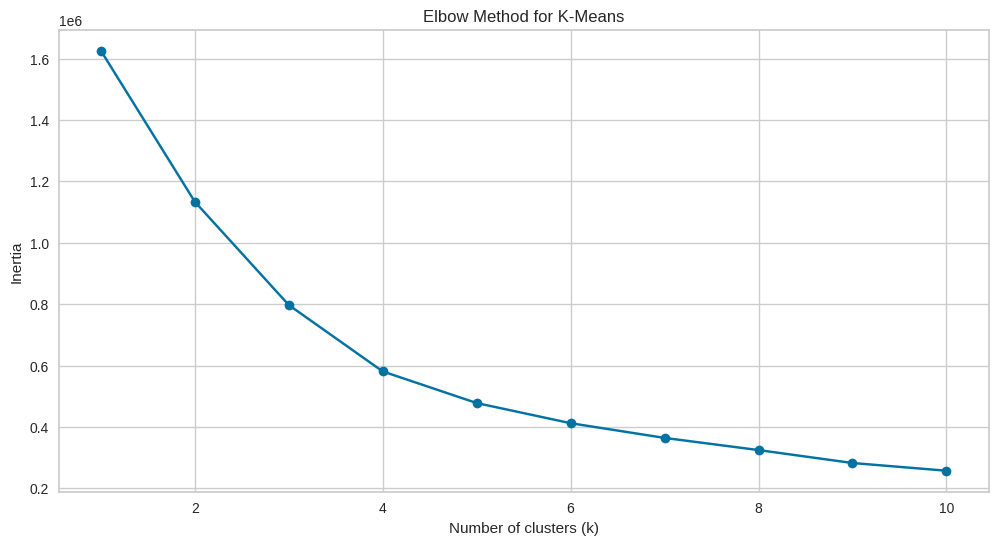

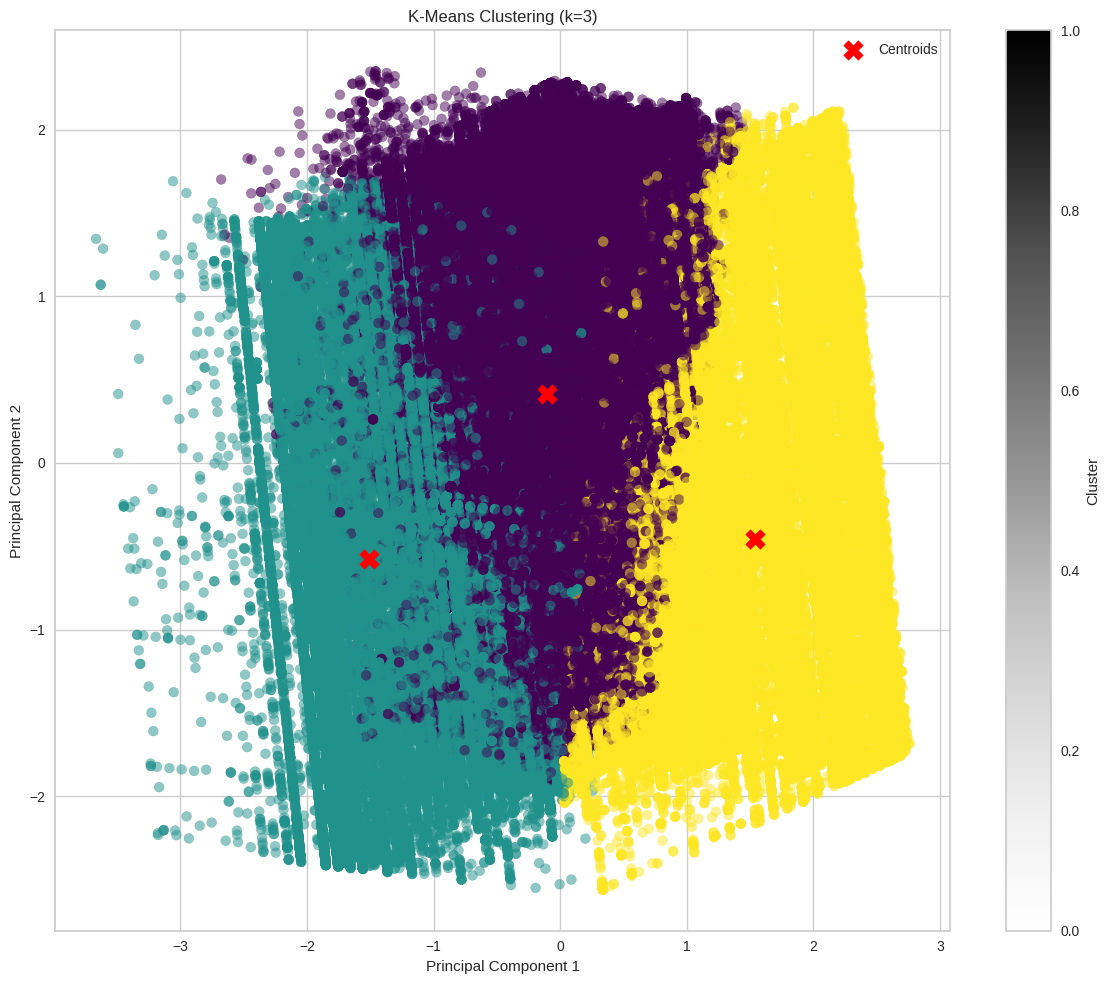

Sampling 5000 points for silhouette calculation
Silhouette score calculated in 1.18 seconds
Silhouette plot created in 0.05 seconds
Cluster visualization created in 0.05 seconds
Total execution time: 1.28 seconds


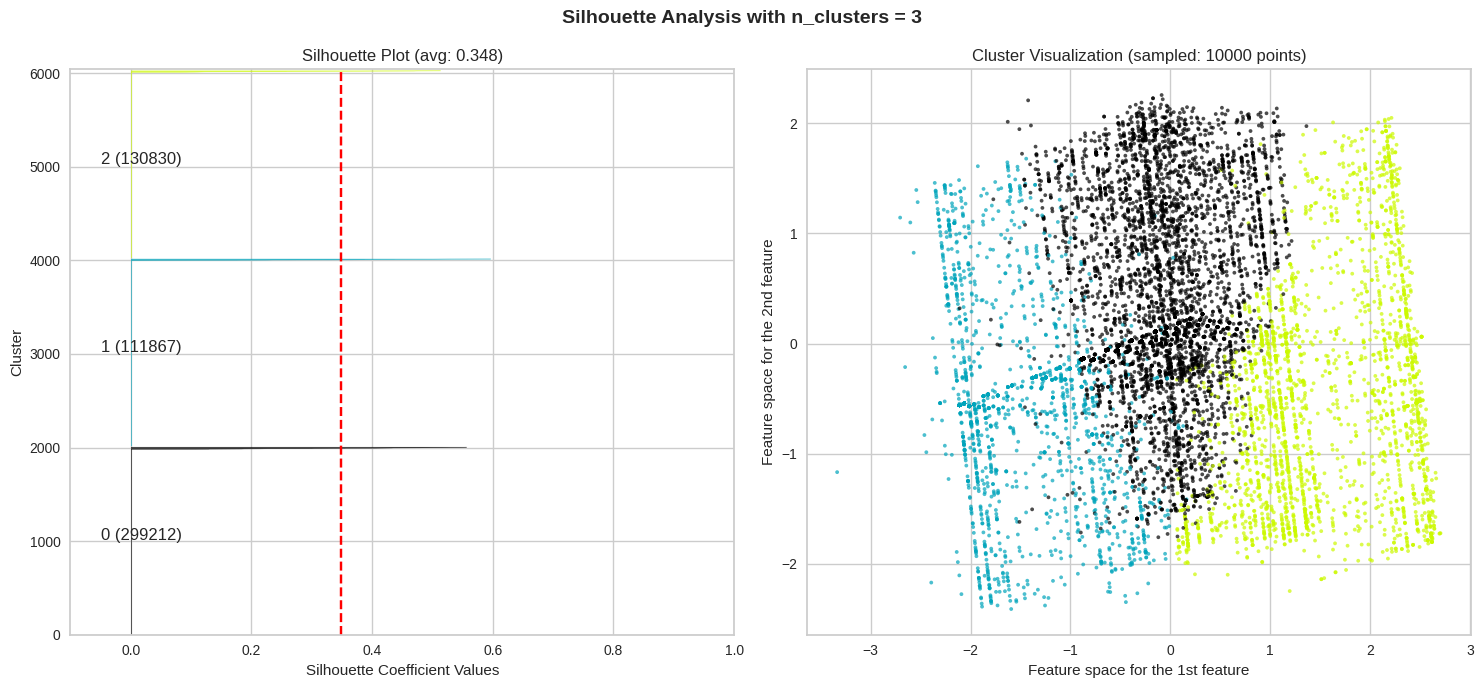

In [10]:
"""
### 4.1 K-Means Clustering
K-Means is a partitioning method that divides the dataset into K distinct clusters.
The algorithm works by:
1. Initializing K centroids randomly
2. Assigning each data point to the nearest centroid
3. Recalculating centroids based on assigned points
4. Repeating 2-3 until convergence
"""

# Determine the optimal number of clusters using the elbow method
def plot_elbow_curve(X, max_k=15):
    """
    Plot the elbow curve to find the optimal number of clusters for K-Means.

    Parameters:
    X (array): Input data
    max_k (int): Maximum number of clusters to consider

    Returns:
    int: Suggested optimal number of clusters
    """
    from yellowbrick.cluster import KElbowVisualizer
    from sklearn.cluster import KMeans

    # Create a new figure
    plt.figure(figsize=(12, 6))

    # Elbow method for inertia
    inertia = []
    K = range(1, max_k + 1)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.plot(K, inertia, 'bo-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for K-Means')
    plt.grid(True)

    # Find the "elbow" point
    from kneed import KneeLocator
    kl = KneeLocator(K, inertia, curve='convex', direction='decreasing')
    optimal_k = kl.elbow

    # Add a vertical line at the elbow point
    if optimal_k:
        plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Elbow at k={optimal_k}')
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot silhouette scores for different k values
    plt.figure(figsize=(12, 6))

    silhouette_scores = []
    for k in K[1:]:  # Skip k=1 as silhouette score needs at least 2 clusters
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        try:
            silhouette_scores.append(silhouette_score(X, labels))
        except:
            silhouette_scores.append(0)

    plt.plot(K[1:], silhouette_scores, 'bo-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score Method for K-Means')
    plt.grid(True)

    # Find the k with the highest silhouette score
    best_k_silhouette = K[1:][np.argmax(silhouette_scores)]
    plt.axvline(x=best_k_silhouette, color='r', linestyle='--',
                label=f'Best k={best_k_silhouette}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Return the suggested optimal number of clusters
    # If elbow point exists, use it; otherwise use the best silhouette score
    return optimal_k if optimal_k else best_k_silhouette

# Find the optimal number of clusters
try:
    optimal_k = plot_elbow_curve(X, max_k=10)
    print(f"Suggested optimal number of clusters: {optimal_k}")
except:
    # Fallback if the elbow method fails
    optimal_k = 3
    print(f"Using default number of clusters: {optimal_k}")

# Train the K-Means model with the optimal number of clusters
start_time = time.time()
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)
kmeans_time = time.time() - start_time

print(f"K-Means clustering completed in {kmeans_time:.2f} seconds")
print(f"Number of clusters: {len(np.unique(kmeans_labels))}")
cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
print("Cluster sizes:")
print(cluster_counts)

# Visualize the K-Means clusters
plt.figure(figsize=(12, 10))

# Use PCA to reduce dimensionality for visualization if needed
if X.shape[1] > 2:
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
else:
    X_pca = X.values

# Plot the clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.5, s=50)

# Plot the centroids
centroids_pca = pca.transform(kmeans.cluster_centers_) if X.shape[1] > 2 else kmeans.cluster_centers_
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='X', s=200, label='Centroids')

plt.title(f'K-Means Clustering (k={optimal_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.colorbar(label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize the silhouette plot for K-Means
plot_silhouette(X, kmeans_labels, optimal_k, max_points_per_cluster=2000, silhouette_sample_size=5000)

# Evaluate K-Means clustering
kmeans_eval = evaluate_clustering(X, kmeans_labels, 'K-Means', sampling_ratio=0.1)
all_evaluations.append(kmeans_eval)

### 4.2 Agglomerative Clustering

Sampling 1000 points from 541909 for dendrogram visualization
Computing linkage matrix for dendrogram...
Linkage matrix computed in 0.02 seconds


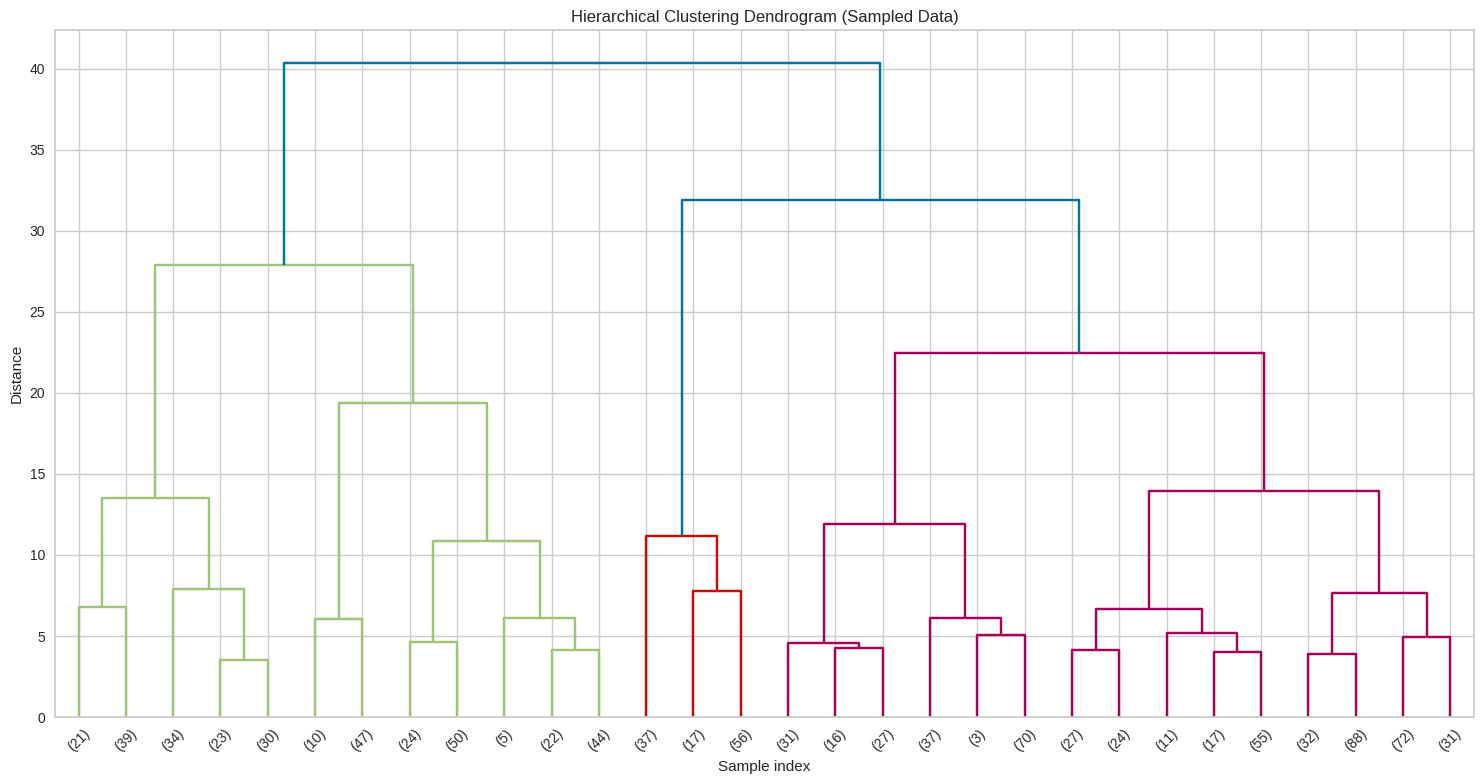

Suggested optimal number of clusters: 7
Suggested number of clusters from dendrogram: 7
Sampling 10000 points to stay within 16 GB limit
Training Agglomerative Clustering on 10000 samples...
Assigning remaining points to nearest clusters...
Processing batch 1/54
Processing batch 2/54
Processing batch 3/54
Processing batch 4/54
Processing batch 5/54
Processing batch 6/54
Processing batch 7/54
Processing batch 8/54
Processing batch 9/54
Processing batch 10/54
Processing batch 11/54
Processing batch 12/54
Processing batch 13/54
Processing batch 14/54
Processing batch 15/54
Processing batch 16/54
Processing batch 17/54
Processing batch 18/54
Processing batch 19/54
Processing batch 20/54
Processing batch 21/54
Processing batch 22/54
Processing batch 23/54
Processing batch 24/54
Processing batch 25/54
Processing batch 26/54
Processing batch 27/54
Processing batch 28/54
Processing batch 29/54
Processing batch 30/54
Processing batch 31/54
Processing batch 32/54
Processing batch 33/54
Processin

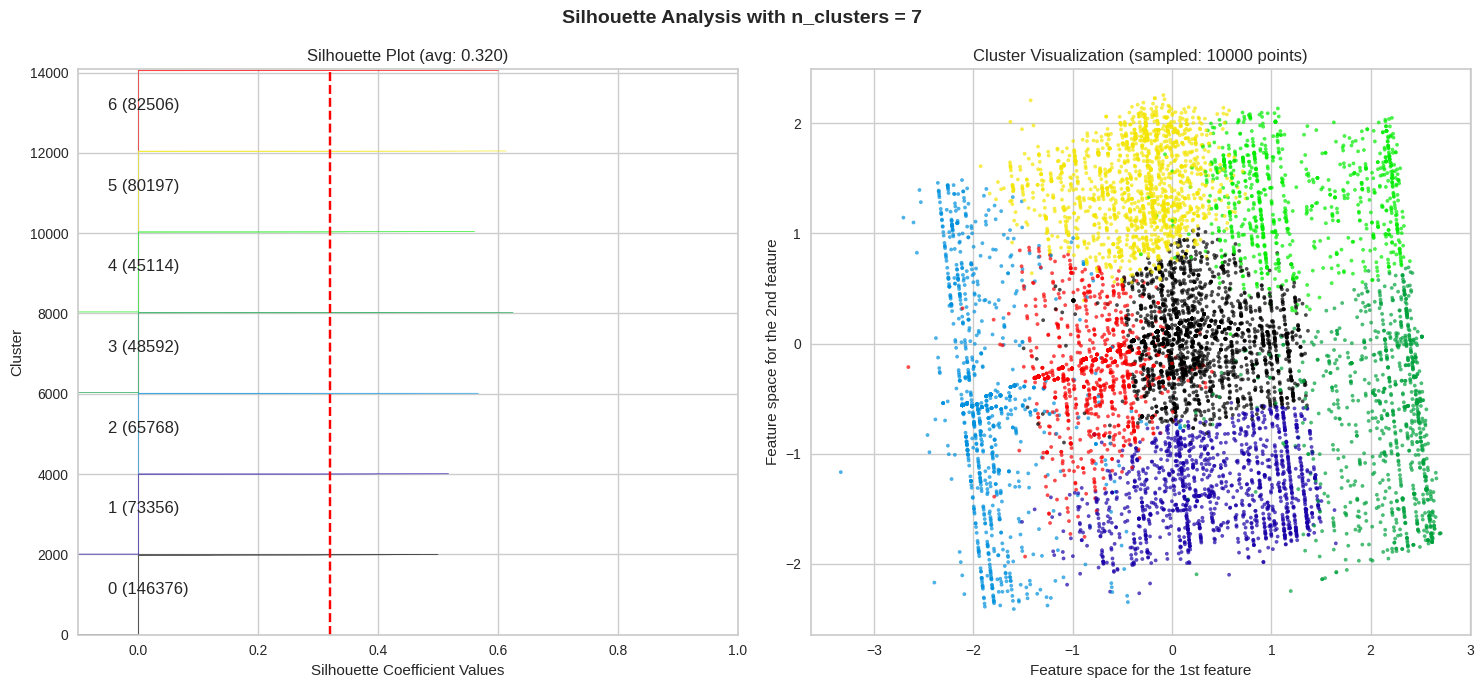

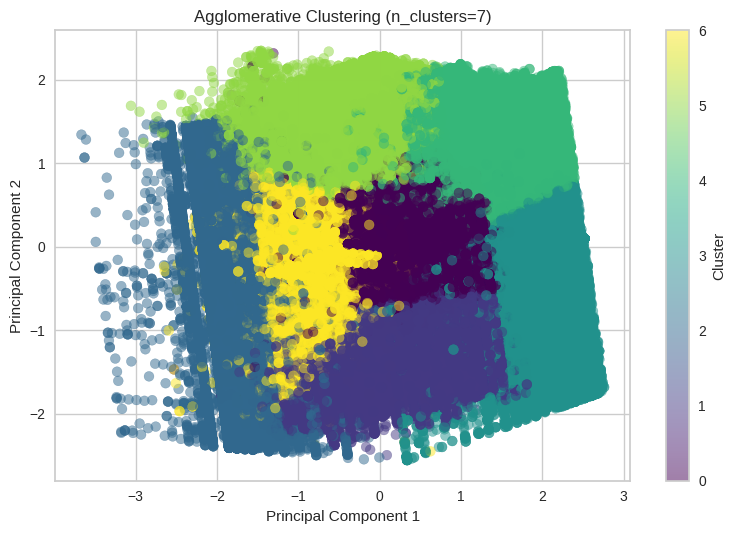

In [11]:
"""
### 4.2 Agglomerative Clustering
Agglomerative clustering is a hierarchical clustering method that builds nested clusters
by merging or splitting them successively. It follows a bottom-up approach:
1. Start with each data point as a separate cluster
2. Merge the two closest clusters based on a linkage criterion
3. Repeat until all clusters are merged into a single cluster
"""

# Function to plot dendrogram to help determine the number of clusters
def optimized_plot_dendrogram(X, max_d=None, sample_size=1000, random_state=42):
    """
    Plot a dendrogram to visualize the hierarchical clustering with optimizations for large datasets.

    Parameters:
    X (array or DataFrame): Input data
    max_d (float): Maximum distance for horizontal cut (optional)
    sample_size (int): Maximum number of samples to use for dendrogram
    random_state (int): Random seed for reproducibility

    Returns:
    int: Suggested number of clusters based on dendrogram
    """
    # Ensure we have a reasonable number of samples for the dendrogram
    if isinstance(X, pd.DataFrame):
        n_samples = X.shape[0]
    else:
        n_samples = len(X)

    if n_samples > sample_size:
        print(f"Sampling {sample_size} points from {n_samples} for dendrogram visualization")
        np.random.seed(random_state)

        if isinstance(X, pd.DataFrame):
            sampled_indices = np.random.choice(range(n_samples), size=sample_size, replace=False)
            X_sampled = X.iloc[sampled_indices].values
        else:
            sampled_indices = np.random.choice(range(n_samples), size=sample_size, replace=False)
            X_sampled = X[sampled_indices]
    else:
        if isinstance(X, pd.DataFrame):
            X_sampled = X.values
        else:
            X_sampled = X

    # Further reduce dimensionality if needed using PCA
    if X_sampled.shape[1] > 50:
        print(f"Reducing dimensions from {X_sampled.shape[1]} to 50 using PCA for dendrogram")
        pca = PCA(n_components=50, random_state=random_state)
        X_sampled = pca.fit_transform(X_sampled)

    # Compute the linkage matrix
    print("Computing linkage matrix for dendrogram...")
    start_time = time.time()
    Z = linkage(X_sampled, method='ward')
    print(f"Linkage matrix computed in {time.time() - start_time:.2f} seconds")

    # Plot the dendrogram
    plt.figure(figsize=(15, 8))
    plt.title('Hierarchical Clustering Dendrogram (Sampled Data)')
    plt.xlabel('Sample index')
    plt.ylabel('Distance')

    dendrogram(Z, truncate_mode='lastp', p=30, leaf_font_size=10)

    # If max_d is provided, draw a horizontal line at that distance
    if max_d:
        plt.axhline(y=max_d, color='r', linestyle='--', label=f'Cut at distance {max_d:.2f}')
        plt.legend()

        # Get the number of clusters at this cut
        n_clusters = len(np.unique(fcluster(Z, max_d, criterion='distance')))
        plt.title(f'Hierarchical Clustering Dendrogram (n_clusters = {n_clusters} at d = {max_d:.2f})')

    plt.tight_layout()
    plt.show()

    # Calculate the optimal number of clusters based on the distances
    # Look at the last 10 merges, or fewer if we have fewer clusters
    last_n = min(10, len(Z) - 1)
    last = Z[-last_n:, 2]
    if len(last) > 2:
        acceleration = np.diff(last, 2)
        idx = np.argmax(acceleration) + 2
        optimal_n = len(last) - idx + 2
    else:
        optimal_n = 2  # Default to 2 clusters if we don't have enough merge steps

    print(f"Suggested optimal number of clusters: {optimal_n}")
    return optimal_n

def run_agglomerative_clustering(X, n_clusters=None, sample_size=10000,
                                linkage_type='ward', connectivity=None,
                                memory_limit_gb=16, random_state=42):
    """
    Run Agglomerative Clustering with optimizations for large datasets

    Parameters:
    X (array or DataFrame): Input data
    n_clusters (int): Number of clusters to find
    sample_size (int): Maximum number of samples to use for clustering
    linkage_type (str): Linkage criterion - 'ward', 'complete', 'average', or 'single'
    connectivity (array): Connectivity matrix (optional)
    memory_limit_gb (float): Maximum memory to use in GB
    random_state (int): Random seed for reproducibility

    Returns:
    tuple: (cluster_labels, time_taken, memory_peak_mb)
    """
    if n_clusters is None:
        # If no n_clusters provided, determine a reasonable default based on data size
        if isinstance(X, pd.DataFrame):
            n_samples = X.shape[0]
        else:
            n_samples = len(X)

        if n_samples < 1000:
            n_clusters = 8
        elif n_samples < 10000:
            n_clusters = 12
        else:
            n_clusters = 15
        print(f"No cluster count specified, using {n_clusters} clusters based on data size")

    # Estimate if we can process the entire dataset
    if isinstance(X, pd.DataFrame):
        n_samples, n_features = X.shape
    else:
        n_samples = len(X)
        n_features = X.shape[1] if len(X.shape) > 1 else 1

    # Agglomerative clustering memory is roughly O(n²) in the worst case
    estimated_memory_gb = (n_samples**2 * 8) / (1024**3)  # 8 bytes per float

    if estimated_memory_gb > memory_limit_gb:
        print(f"Warning: Full dataset would require ~{estimated_memory_gb:.1f} GB memory")
        print(f"Sampling {sample_size} points to stay within {memory_limit_gb} GB limit")

        np.random.seed(random_state)
        if isinstance(X, pd.DataFrame):
            sampled_indices = np.random.choice(range(n_samples), size=sample_size, replace=False)
            X_sample = X.iloc[sampled_indices]
            X_full = X
        else:
            sampled_indices = np.random.choice(range(n_samples), size=sample_size, replace=False)
            X_sample = X[sampled_indices]
            X_full = X

        # Train on sample
        start_time = time.time()
        print(f"Training Agglomerative Clustering on {sample_size} samples...")
        mem_usage = memory_usage((AgglomerativeClustering(
            n_clusters=n_clusters,
            linkage=linkage_type,
            connectivity=connectivity
        ).fit_predict, (X_sample,)), interval=0.1, max_iterations=1)

        agglo = AgglomerativeClustering(
            n_clusters=n_clusters,
            linkage=linkage_type,
            connectivity=connectivity
        )
        sample_labels = agglo.fit_predict(X_sample)
        training_time = time.time() - start_time

        # Now we need to assign the rest of the points to clusters
        print("Assigning remaining points to nearest clusters...")

        # For each cluster, find a centroid
        centroids = []
        for i in range(n_clusters):
            if isinstance(X_sample, pd.DataFrame):
                mask = sample_labels == i
                centroids.append(X_sample.iloc[mask].mean().values)
            else:
                mask = sample_labels == i
                centroids.append(X_sample[mask].mean(axis=0))
        centroids = np.array(centroids)

        # Initialize full labels
        full_labels = np.zeros(n_samples, dtype=int)
        full_labels[sampled_indices] = sample_labels

        # Process the full dataset in batches to avoid memory issues
        batch_size = 10000
        non_sampled_indices = np.setdiff1d(np.arange(n_samples), sampled_indices)

        for i in range(0, len(non_sampled_indices), batch_size):
            batch_indices = non_sampled_indices[i:i+batch_size]
            print(f"Processing batch {i//batch_size + 1}/{(len(non_sampled_indices)-1)//batch_size + 1}")

            if isinstance(X_full, pd.DataFrame):
                batch_data = X_full.iloc[batch_indices].values
            else:
                batch_data = X_full[batch_indices]

            # Calculate distances to all centroids
            distances = np.zeros((len(batch_indices), n_clusters))
            for j in range(n_clusters):
                distances[:, j] = np.sqrt(((batch_data - centroids[j])**2).sum(axis=1))

            # Assign to nearest centroid
            batch_labels = np.argmin(distances, axis=1)
            full_labels[batch_indices] = batch_labels

        clustering_time = time.time() - start_time
        peak_memory = max(mem_usage)

        print(f"Agglomerative clustering completed in {clustering_time:.2f} seconds")
        print(f"Peak memory usage: {peak_memory:.2f} MB")

        return full_labels, clustering_time, peak_memory

    else:
        # We can process the entire dataset
        print(f"Processing full dataset with Agglomerative Clustering...")
        start_time = time.time()

        mem_usage = memory_usage((AgglomerativeClustering(
            n_clusters=n_clusters,
            linkage=linkage_type,
            connectivity=connectivity
        ).fit_predict, (X,)), interval=0.1, max_iterations=1)

        agglo = AgglomerativeClustering(
            n_clusters=n_clusters,
            linkage=linkage_type,
            connectivity=connectivity
        )
        labels = agglo.fit_predict(X)

        clustering_time = time.time() - start_time
        peak_memory = max(mem_usage)

        print(f"Agglomerative clustering completed in {clustering_time:.2f} seconds")
        print(f"Peak memory usage: {peak_memory:.2f} MB")

        return labels, clustering_time, peak_memory


# Determine optimal number of clusters (with sampling for speed)
optimal_n_agglo = optimized_plot_dendrogram(X, sample_size=1000)
print(f"Suggested number of clusters from dendrogram: {optimal_n_agglo}")

# Run optimized agglomerative clustering
agglo_labels, agglo_time, agglo_memory = run_agglomerative_clustering(
    X,
    n_clusters=optimal_n_agglo,
    sample_size=10000,  # Adjust based on your system capabilities
    memory_limit_gb=16  # Set to available memory on your system
)

print(f"Agglomerative clustering completed in {agglo_time:.2f} seconds")
print(f"Peak memory usage: {agglo_memory:.2f} MB")
print(f"Number of clusters: {len(np.unique(agglo_labels))}")

# Display cluster sizes
cluster_counts = pd.Series(agglo_labels).value_counts().sort_index()
print("Cluster sizes:")
print(cluster_counts)

# Visualize the silhouette plot
plot_silhouette(X, agglo_labels, optimal_n_agglo, max_points_per_cluster=2000, silhouette_sample_size=5000)

# Plot the clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agglo_labels, cmap='viridis', alpha=0.5, s=50)

plt.title(f'Agglomerative Clustering (n_clusters={optimal_n_agglo})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate Agglomerative Clustering
agglo_eval = evaluate_clustering(X, agglo_labels, 'Agglomerative', sampling_ratio=0.1)
all_evaluations.append(agglo_eval)

### 4.3 DBSCAN Clustering

Best DBSCAN parameters: eps=0.30, min_samples=20
Silhouette score: 0.4194
Number of clusters: 2
Noise points: 633 (6.33%)


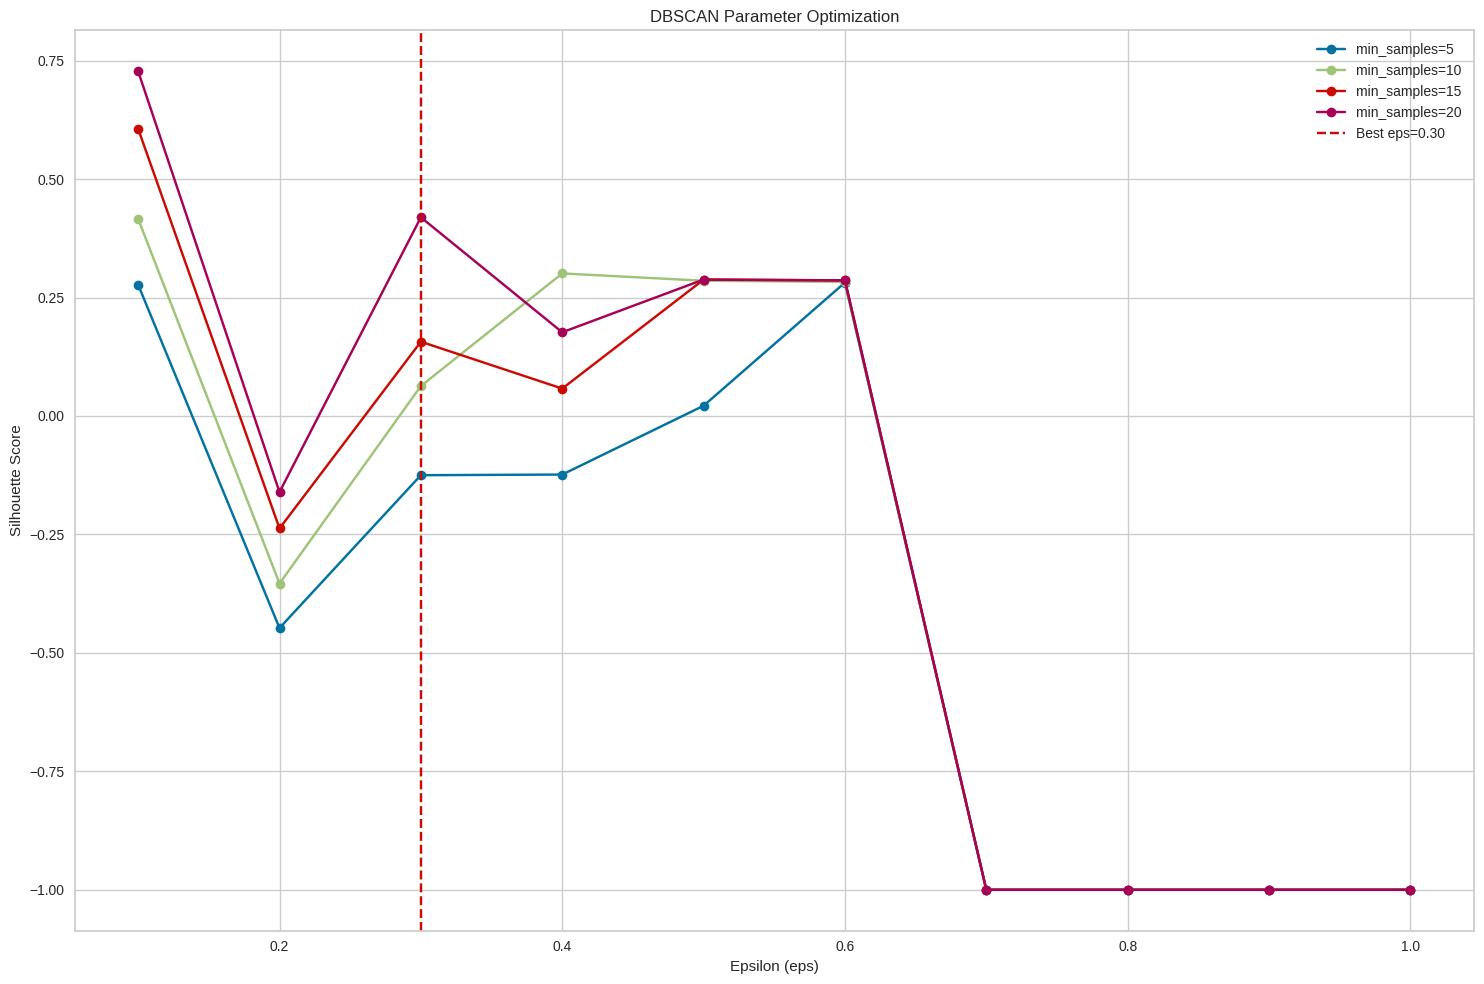

Starting DBSCAN clustering analysis...
Best DBSCAN parameters: eps=0.10, min_samples=10
Silhouette score: 0.3764
Number of clusters: 137
Noise points: 4712 (47.12%)


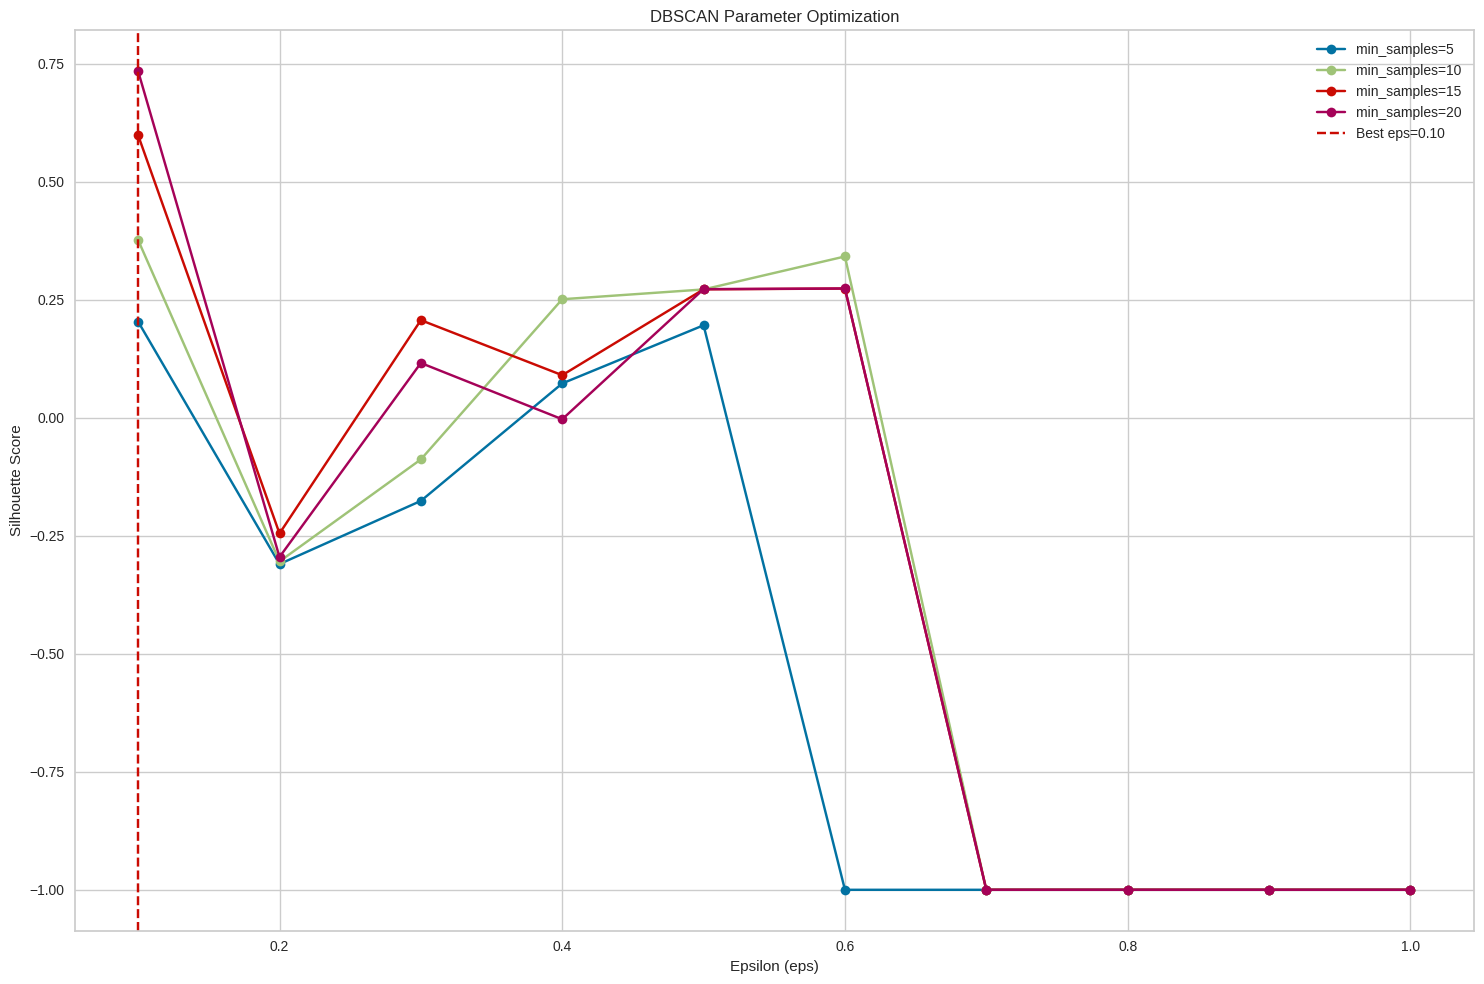

Fitting DBSCAN with optimal parameters...
DBSCAN clustering completed in 44.93 seconds
Number of clusters: 598
Number of noise points: 10191 (1.88%)
Cluster sizes:
-1      10191
 0      31908
 1       1160
 2       9229
 3      20143
        ...  
 593       10
 594       10
 595       10
 596       12
 597       10
Name: count, Length: 599, dtype: int64
Error in visualization: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (599,) + inhomogeneous part.
Sampling 5000 points for silhouette calculation
Silhouette score calculated in 0.90 seconds
Silhouette plot created in 2.77 seconds
Cluster visualization created in 0.03 seconds
Total execution time: 3.70 seconds


<Figure size 1200x1000 with 0 Axes>

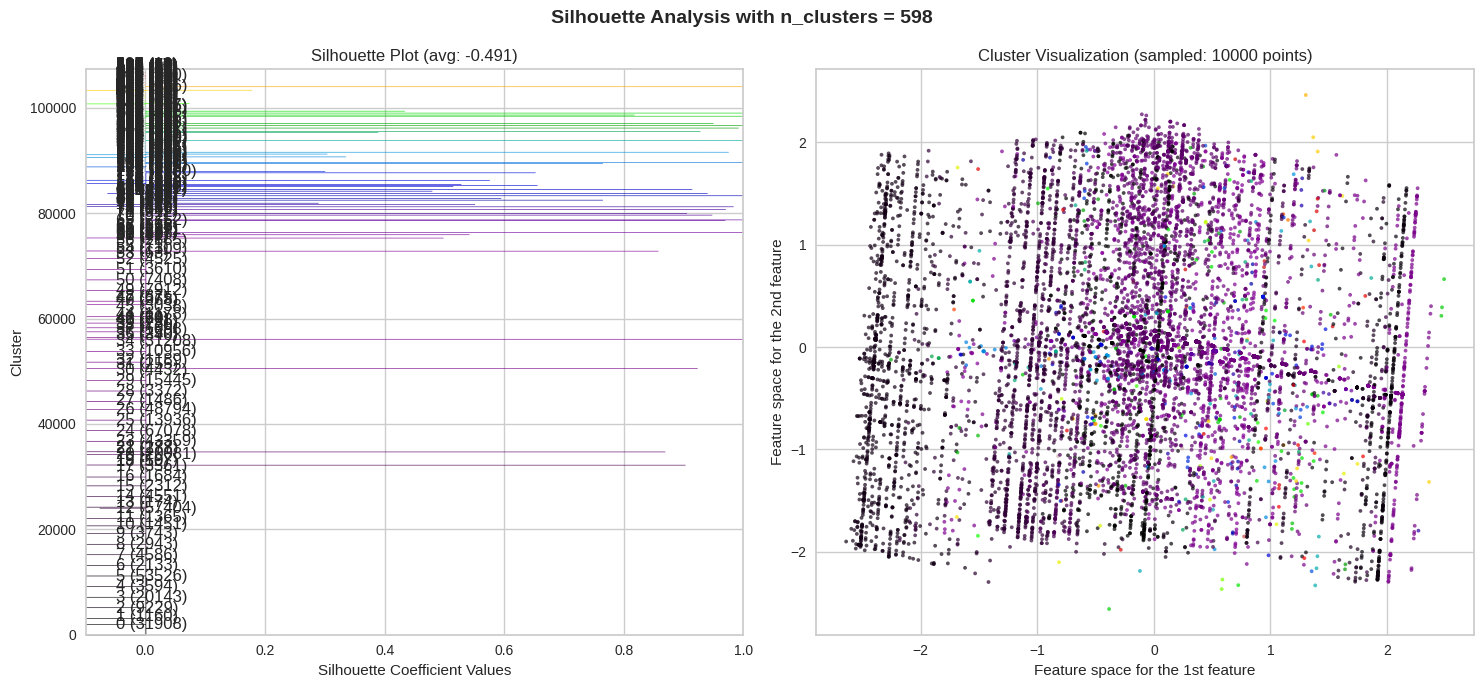

In [12]:
"""
### 4.3 DBSCAN Clustering
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm
that groups together points that are closely packed together. It can find arbitrarily shaped clusters and
identify noise points.
"""

# Function to find optimal DBSCAN parameters
def find_optimal_dbscan_params(X, min_eps=0.1, max_eps=1.0, n_eps=10, min_samples_range=[5, 10, 15, 20]):
    """
    Find optimal parameters for DBSCAN using a grid search approach with better error handling.

    Parameters:
    X (array-like): Input data
    min_eps (float): Minimum epsilon value
    max_eps (float): Maximum epsilon value
    n_eps (int): Number of epsilon values to try
    min_samples_range (list): Range of min_samples values to try

    Returns:
    tuple: Optimal (eps, min_samples) combination
    """
    # Convert X to numpy array if it's a pandas DataFrame
    if isinstance(X, pd.DataFrame):
        X = X.values

    eps_range = np.linspace(min_eps, max_eps, n_eps)

    best_score = -1
    best_params = (0.5, 5)  # Default parameters

    # Evaluate parameters for a single combination
    def evaluate_params(eps, min_samples):
        try:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)

            # Count the number of clusters (excluding noise points with label -1)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            # Only evaluate if there are at least 2 clusters
            if n_clusters >= 2:
                # Remove noise points for evaluation
                mask = labels != -1
                if np.sum(mask) > n_clusters:  # Ensure we have enough points for silhouette
                    score = silhouette_score(X[mask], labels[mask], sample_size=min(10000, np.sum(mask)))
                    return eps, min_samples, score, n_clusters, np.sum(labels == -1)

            return eps, min_samples, -1, n_clusters, np.sum(labels == -1)
        except Exception as e:
            print(f"Error evaluating DBSCAN with eps={eps}, min_samples={min_samples}: {e}")
            return eps, min_samples, -1, 0, 0

    # Create a list of all parameter combinations
    param_combinations = [(eps, min_samples) for eps in eps_range for min_samples in min_samples_range]

    # Evaluate all combinations - use smaller n_jobs to avoid memory issues
    results = Parallel(n_jobs=4)(delayed(evaluate_params)(eps, min_samples)
                               for eps, min_samples in param_combinations)

    # Create a DataFrame for easier analysis
    results_df = pd.DataFrame(results, columns=['eps', 'min_samples', 'silhouette', 'n_clusters', 'n_noise'])

    # Filter valid results (at least 2 clusters and not too many noise points)
    valid_results = results_df[(results_df['n_clusters'] >= 2) &
                              (results_df['silhouette'] > 0) &
                              (results_df['n_noise'] < len(X) * 0.5)]

    if not valid_results.empty:
        # Find the parameters with the best silhouette score
        best_idx = valid_results['silhouette'].idxmax()
        best_params = (valid_results.loc[best_idx, 'eps'], int(valid_results.loc[best_idx, 'min_samples']))
        best_score = valid_results.loc[best_idx, 'silhouette']
        n_clusters = valid_results.loc[best_idx, 'n_clusters']
        n_noise = valid_results.loc[best_idx, 'n_noise']

        print(f"Best DBSCAN parameters: eps={best_params[0]:.2f}, min_samples={best_params[1]}")
        print(f"Silhouette score: {best_score:.4f}")
        print(f"Number of clusters: {n_clusters}")
        print(f"Noise points: {n_noise} ({n_noise/len(X)*100:.2f}%)")
    else:
        print("No valid DBSCAN parameters found. Using defaults.")

    # Visualize the results if we have valid results
    try:
        if not results_df.empty and not valid_results.empty:
            plt.figure(figsize=(15, 10))
            for i, min_samples in enumerate(min_samples_range):
                data = results_df[results_df['min_samples'] == min_samples]
                plt.plot(data['eps'], data['silhouette'], marker='o', label=f'min_samples={min_samples}')

            plt.axvline(x=best_params[0], color='r', linestyle='--',
                        label=f'Best eps={best_params[0]:.2f}')
            plt.xlabel('Epsilon (eps)')
            plt.ylabel('Silhouette Score')
            plt.title('DBSCAN Parameter Optimization')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error plotting parameter optimization results: {e}")

    return best_params

# Find optimal DBSCAN parameters
# For large datasets, we'll use a subset to speed up the parameter search
if X.shape[0] > 10000:
    sample_size = min(10000, X.shape[0])
    sampled_indices = np.random.choice(range(X.shape[0]), size=sample_size, replace=False)
    X_sampled = X.iloc[sampled_indices]
else:
    X_sampled = X

try:
    optimal_eps, optimal_min_samples = find_optimal_dbscan_params(X_sampled)
except Exception as e:
    print(f"Error in finding optimal DBSCAN parameters: {e}")
    # Use default parameters if optimization fails
    optimal_eps, optimal_min_samples = 0.5, 5
    print(f"Using default parameters: eps={optimal_eps}, min_samples={optimal_min_samples}")

print("Starting DBSCAN clustering analysis...")

# Convert X to numpy array if it's a pandas DataFrame
if isinstance(X, pd.DataFrame):
    X_data = X.values
else:
    X_data = X

# Extract a sample for parameter search if data is large
if X_data.shape[0] > 10000:
    sample_size = min(10000, X_data.shape[0])
    sampled_indices = np.random.choice(range(X_data.shape[0]), size=sample_size, replace=False)
    X_sampled = X_data[sampled_indices]
else:
    X_sampled = X_data

# Find optimal parameters
try:
    optimal_eps, optimal_min_samples = find_optimal_dbscan_params(X_sampled)
except Exception as e:
    print(f"Error in finding optimal DBSCAN parameters: {e}")
    # Use default parameters if optimization fails
    optimal_eps, optimal_min_samples = 0.5, 5
    print(f"Using default parameters: eps={optimal_eps}, min_samples={optimal_min_samples}")

# Train the DBSCAN model with the optimal parameters
print("Fitting DBSCAN with optimal parameters...")
start_time = time.time()
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(X_data)
dbscan_time = time.time() - start_time

print(f"DBSCAN clustering completed in {dbscan_time:.2f} seconds")
n_clusters = len(np.unique(dbscan_labels[dbscan_labels != -1]))
print(f"Number of clusters: {n_clusters}")
noise_count = np.sum(dbscan_labels == -1)
print(f"Number of noise points: {noise_count} ({noise_count/len(dbscan_labels)*100:.2f}%)")

# Show cluster sizes
try:
    cluster_counts = pd.Series(dbscan_labels).value_counts().sort_index()
    print("Cluster sizes:")
    print(cluster_counts)
except Exception as e:
    print(f"Error displaying cluster sizes: {e}")

# Visualize the DBSCAN clusters using PCA if needed
try:
    plt.figure(figsize=(12, 10))

    # Use PCA to reduce dimensionality for visualization if needed
    if X_data.shape[1] > 2:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_data)
    else:
        X_pca = X_data

    # Create a custom colormap for DBSCAN (with black for noise points)
    unique_labels = np.unique(dbscan_labels)
    colors = np.array(['black'] + list(plt.cm.viridis(np.linspace(0, 1, len(unique_labels) - 1 if -1 in unique_labels else len(unique_labels)))))

    # Map labels to color indices
    color_indices = np.zeros(dbscan_labels.shape, dtype=int)
    for i, label in enumerate(unique_labels):
        color_indices[dbscan_labels == label] = i

    # Plot the clusters - sample if very large
    if len(X_pca) > 50000:
        sample_idx = np.random.choice(len(X_pca), size=50000, replace=False)
        plt.scatter(X_pca[sample_idx, 0], X_pca[sample_idx, 1],
                    c=[colors[i] for i in color_indices[sample_idx]],
                    alpha=0.5, s=50)
    else:
        plt.scatter(X_pca[:, 0], X_pca[:, 1],
                    c=[colors[i] for i in color_indices],
                    alpha=0.5, s=50)

    plt.title(f'DBSCAN Clustering (eps={optimal_eps:.2f}, min_samples={optimal_min_samples})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.tight_layout()

    # Add a legend for the noise points
    noise_patch = plt.plot([0], [0], 'o', color='black', label='Noise', alpha=0.5)[0]
    plt.legend(handles=[noise_patch])

    plt.show()
except Exception as e:
    print(f"Error in visualization: {e}")

# Evaluate with silhouette plot if appropriate
if n_clusters > 1 and np.any(dbscan_labels != -1):
    try:
        # Create a mask for non-noise points
        mask = dbscan_labels != -1
        if np.sum(mask) > 1 and len(np.unique(dbscan_labels[mask])) > 1:
            plot_silhouette(X_data[mask], dbscan_labels[mask], len(np.unique(dbscan_labels[mask])),
                          max_points_per_cluster=2000, silhouette_sample_size=5000)
    except Exception as e:
        print(f"Error in silhouette analysis: {e}")

# Evaluate DBSCAN clustering
dbscan_eval = evaluate_clustering(X_data, dbscan_labels, 'DBSCAN', sampling_ratio=0.1)
all_evaluations.append(dbscan_eval)


### 4.4 Gaussian Mixture Model

Starting Gaussian Mixture Model clustering analysis...
Error in finding optimal GMM components: name 'max_components' is not defined
Using default number of components: 3
Fitting GMM with 3 components...
GMM clustering completed in 30.31 seconds
Number of components: 3
Cluster sizes:
0    228219
1    209068
2    104622
Name: count, dtype: int64


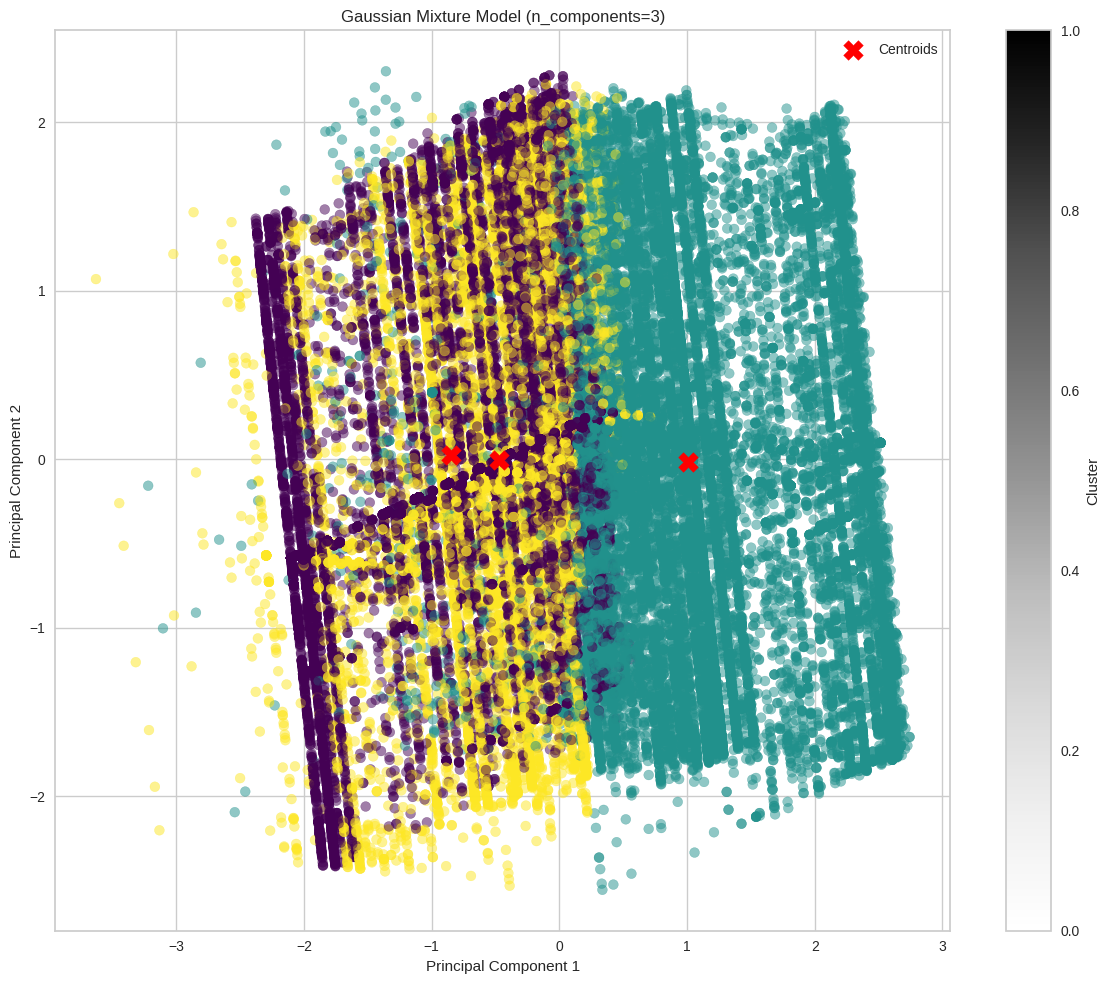

Sampling 5000 points for silhouette calculation
Silhouette score calculated in 0.89 seconds
Silhouette plot created in 0.03 seconds
Cluster visualization created in 0.02 seconds
Total execution time: 0.94 seconds


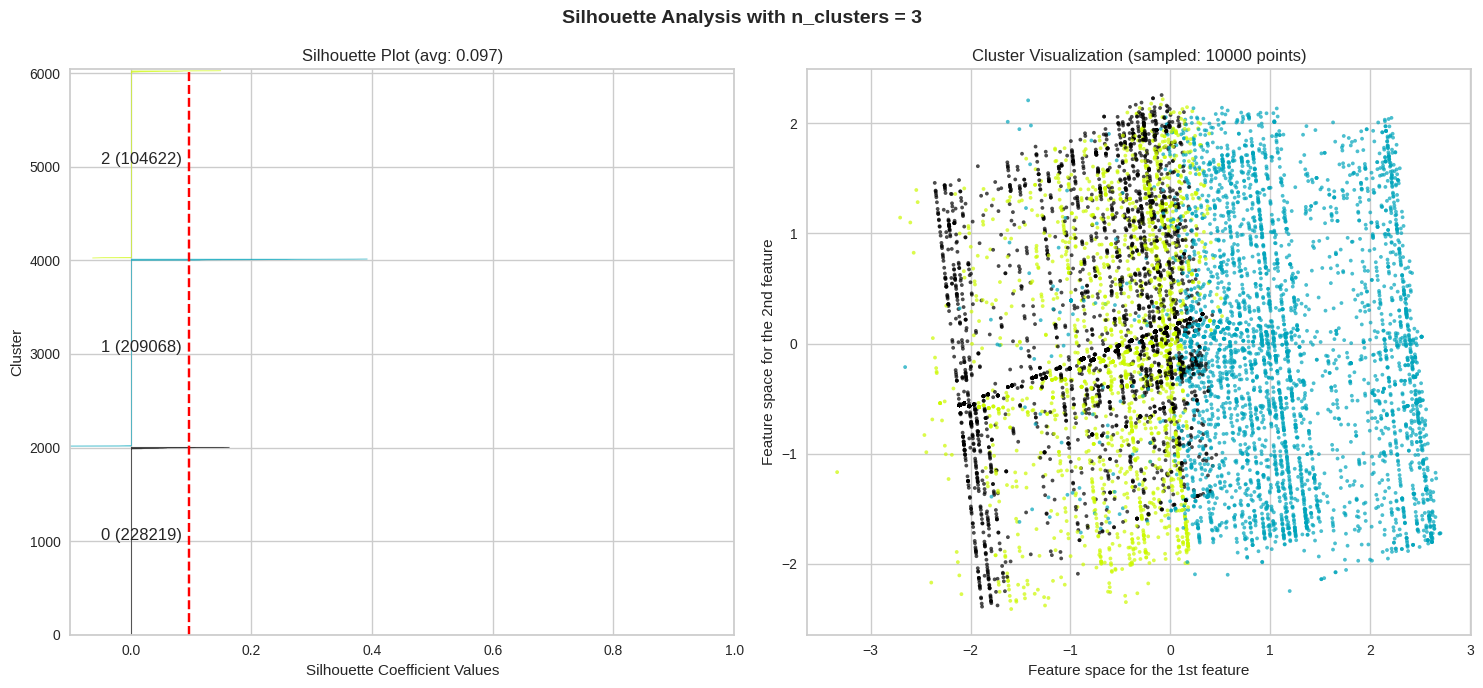

In [13]:

"""
### 4.4 Gaussian Mixture Model
Gaussian Mixture Models (GMM) are probabilistic models that assume the data is generated
from a mixture of several Gaussian distributions. Each cluster is represented by a Gaussian
distribution with its own mean and covariance.
"""

# Function to determine the optimal number of components for GMM
# Function to determine the optimal number of components for GMM with better error handling
def find_optimal_gmm_components(X, max_components=10, sample_size=10000):
    """
    Find the optimal number of components for Gaussian Mixture Model using BIC.

    Parameters:
    X (array-like): Input data
    max_components (int): Maximum number of components to consider
    sample_size (int): Maximum sample size to use for computation

    Returns:
    int: Optimal number of components
    """
    # Convert X to numpy array if it's a pandas DataFrame
    if isinstance(X, pd.DataFrame):
        X = X.values

    # Sample data if it's too large
    if X.shape[0] > sample_size:
        print(f"Sampling {sample_size} points for GMM optimization...")
        sampled_indices = np.random.choice(range(X.shape[0]), size=sample_size, replace=False)
        X_sample = X[sampled_indices]
    else:
        X_sample = X

    print(f"Finding optimal number of components for GMM (1 to {max_components})...")
    n_components_range = range(1, max_components + 1)
    bic_scores = []
    aic_scores = []
    silhouette_scores = []

    for n_components in n_components_range:
        try:
            print(f"Testing GMM with {n_components} components...")
            gmm = GaussianMixture(
                n_components=n_components,
                covariance_type='full',
                random_state=42,
                max_iter=200,  # Increase max iterations
                n_init=3       # Try multiple initializations
            )
            gmm.fit(X_sample)

            # Calculate BIC and AIC
            bic_scores.append(gmm.bic(X_sample))
            aic_scores.append(gmm.aic(X_sample))

            # Calculate silhouette score if there's more than one component
            if n_components > 1:
                labels = gmm.predict(X_sample)
                unique_labels = np.unique(labels)

                # Only calculate silhouette if we have at least 2 clusters with data points
                if len(unique_labels) > 1:
                    try:
                        # Use a smaller sample for silhouette calculation if needed
                        if X_sample.shape[0] > 5000:
                            subsample_indices = np.random.choice(range(X_sample.shape[0]), size=5000, replace=False)
                            subsample_X = X_sample[subsample_indices]
                            subsample_labels = labels[subsample_indices]
                            score = silhouette_score(subsample_X, subsample_labels)
                        else:
                            score = silhouette_score(X_sample, labels)
                        silhouette_scores.append(score)
                    except Exception as e:
                        print(f"Error calculating silhouette score for {n_components} components: {e}")
                        silhouette_scores.append(0)
                else:
                    print(f"Not enough unique clusters for silhouette score with {n_components} components")
                    silhouette_scores.append(0)
            else:
                silhouette_scores.append(0)

        except Exception as e:
            print(f"Error fitting GMM with {n_components} components: {e}")
            bic_scores.append(float('inf'))
            aic_scores.append(float('inf'))
            silhouette_scores.append(0)

    # Plot scores only if we have valid results
    if len(bic_scores) > 0 and not all(s == float('inf') for s in bic_scores):
        try:
            # Plot BIC and AIC scores
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.plot(n_components_range, bic_scores, 'bo-', label='BIC')
            plt.plot(n_components_range, aic_scores, 'go-', label='AIC')
            plt.xlabel('Number of components')
            plt.ylabel('Score')
            plt.title('BIC and AIC Scores for GMM')
            plt.legend()
            plt.grid(True)

            # Plot silhouette scores if we have components > 1
            if len(silhouette_scores) > 1:
                plt.subplot(1, 2, 2)
                plt.plot(n_components_range[1:], silhouette_scores[1:], 'ro-', label='Silhouette Score')
                plt.xlabel('Number of components')
                plt.ylabel('Silhouette Score')
                plt.title('Silhouette Score for GMM')
                plt.legend()
                plt.grid(True)

            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error plotting GMM component results: {e}")

    # Find the optimal number of components with error handling
    try:
        # Find valid BIC scores (not infinity)
        valid_bic_indices = [i for i, score in enumerate(bic_scores) if score != float('inf')]

        if valid_bic_indices:
            # Find the minimum valid BIC score
            min_bic_idx = min(valid_bic_indices, key=lambda i: bic_scores[i])
            optimal_n_components_bic = n_components_range[min_bic_idx]

            # Find valid silhouette scores (for n_components > 1)
            valid_silhouette_indices = [i for i, score in enumerate(silhouette_scores[1:])
                                     if score > 0 and i+1 < len(n_components_range)]

            if valid_silhouette_indices:
                # Find the maximum valid silhouette score
                max_silhouette_idx = max(valid_silhouette_indices, key=lambda i: silhouette_scores[i+1])
                optimal_n_components_silhouette = n_components_range[max_silhouette_idx+1]

                print(f"Optimal number of components based on BIC: {optimal_n_components_bic}")
                print(f"Optimal number of components based on Silhouette: {optimal_n_components_silhouette}")

                # Choose the optimal number based on both metrics
                if silhouette_scores[optimal_n_components_silhouette-1] > 0.5:
                    # If silhouette score is high, prefer it
                    return optimal_n_components_silhouette
                else:
                    # Otherwise use BIC
                    return optimal_n_components_bic
            else:
                print(f"No valid silhouette scores. Using BIC optimal: {optimal_n_components_bic}")
                return optimal_n_components_bic
        else:
            print("No valid BIC scores. Using default of 3 components.")
            return 3
    except Exception as e:
        print(f"Error determining optimal number of components: {e}")
        return 3  # Default fallback

print("Starting Gaussian Mixture Model clustering analysis...")

# Convert X to numpy array if it's a pandas DataFrame
if isinstance(X, pd.DataFrame):
    X_data = X.values
else:
    X_data = X

# Find the optimal number of components for GMM
try:
    optimal_n_components = find_optimal_gmm_components(X_data, max_components=max_components)
except Exception as e:
    print(f"Error in finding optimal GMM components: {e}")
    # Use default number of components if optimization fails
    optimal_n_components = min(3, X_data.shape[1])
    print(f"Using default number of components: {optimal_n_components}")

# Train the GMM model with the optimal number of components
print(f"Fitting GMM with {optimal_n_components} components...")
start_time = time.time()


gmm = GaussianMixture(
    n_components=optimal_n_components,
    covariance_type='full',
    random_state=42,
    max_iter=200,  # Increase max iterations for better convergence
    n_init=3       # Try multiple initializations
)
gmm.fit(X_data)
gmm_labels = gmm.predict(X_data)
gmm_time = time.time() - start_time

print(f"GMM clustering completed in {gmm_time:.2f} seconds")
print(f"Number of components: {optimal_n_components}")

# Show cluster sizes
try:
    cluster_counts = pd.Series(gmm_labels).value_counts().sort_index()
    print("Cluster sizes:")
    print(cluster_counts)
except Exception as e:
    print(f"Error displaying cluster sizes: {e}")

# Visualize the GMM clusters using PCA if needed
try:
    plt.figure(figsize=(12, 10))

    # Use PCA to reduce dimensionality for visualization if needed
    if X_data.shape[1] > 2:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_data)
        centers_pca = pca.transform(gmm.means_)
    else:
        X_pca = X_data
        centers_pca = gmm.means_

    # Sample if the dataset is very large
    if len(X_pca) > 50000:
        sample_idx = np.random.choice(len(X_pca), size=50000, replace=False)
        plt.scatter(X_pca[sample_idx, 0], X_pca[sample_idx, 1],
                    c=gmm_labels[sample_idx], cmap='viridis', alpha=0.5, s=50)
    else:
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis', alpha=0.5, s=50)

    # Plot the cluster centers
    plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', s=200, label='Centroids')

    plt.title(f'Gaussian Mixture Model (n_components={optimal_n_components})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.colorbar(label='Cluster')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error in visualization: {e}")

# Visualize the silhouette plot for GMM
plot_silhouette(X, gmm_labels, optimal_n_components,  max_points_per_cluster=2000, silhouette_sample_size=5000)

# Evaluate GMM clustering
gmm_eval = evaluate_clustering(X, gmm_labels, 'GMM', sampling_ratio=0.1)
all_evaluations.append(gmm_eval)


### 4.5 Spectral Clustering

Starting Spectral Clustering analysis...
Sampling 2000 points for Spectral Clustering optimization...
Finding optimal number of clusters for Spectral Clustering (2 to 10)...
Testing Spectral Clustering with 2 clusters...
Silhouette score for n_clusters=2: 0.2334
Testing Spectral Clustering with 3 clusters...
Silhouette score for n_clusters=3: 0.2503
Testing Spectral Clustering with 4 clusters...
Silhouette score for n_clusters=4: 0.2383
Testing Spectral Clustering with 5 clusters...
Silhouette score for n_clusters=5: 0.2716
Testing Spectral Clustering with 6 clusters...
Silhouette score for n_clusters=6: 0.1866
Testing Spectral Clustering with 7 clusters...
Silhouette score for n_clusters=7: 0.0445
Testing Spectral Clustering with 8 clusters...
Silhouette score for n_clusters=8: 0.0768
Testing Spectral Clustering with 9 clusters...
Silhouette score for n_clusters=9: 0.1116
Testing Spectral Clustering with 10 clusters...
Silhouette score for n_clusters=10: 0.1402


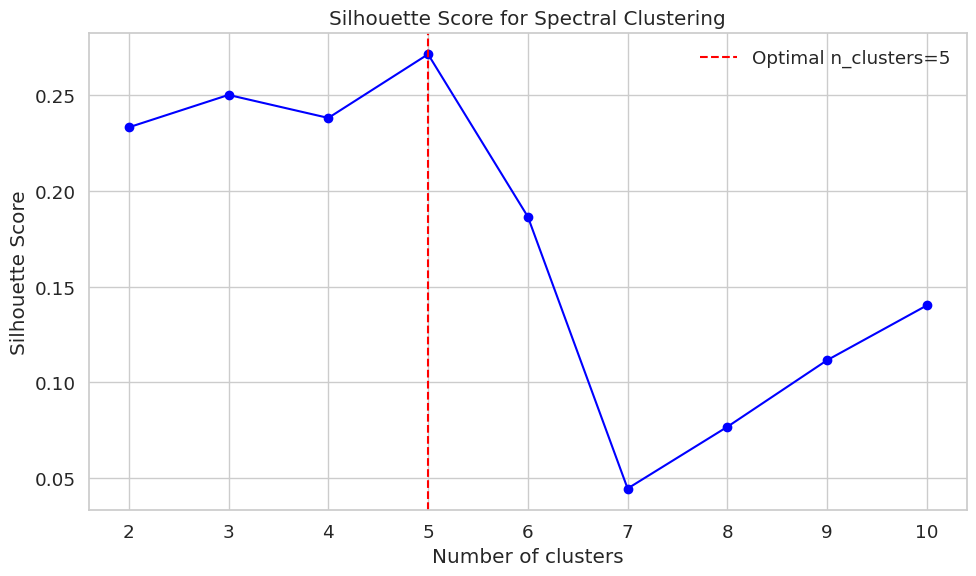

Optimal number of clusters for Spectral Clustering: 5 (silhouette score: 0.2716)
Fitting Spectral Clustering with 5 clusters...
Dataset is large (541909 samples). Using 10000 samples for spectral clustering and propagating labels.
Spectral Clustering completed in 52.98 seconds
Number of clusters: 8
Cluster sizes:
0    531549
1       481
2       304
3      7312
4      2263
Name: count, dtype: int64


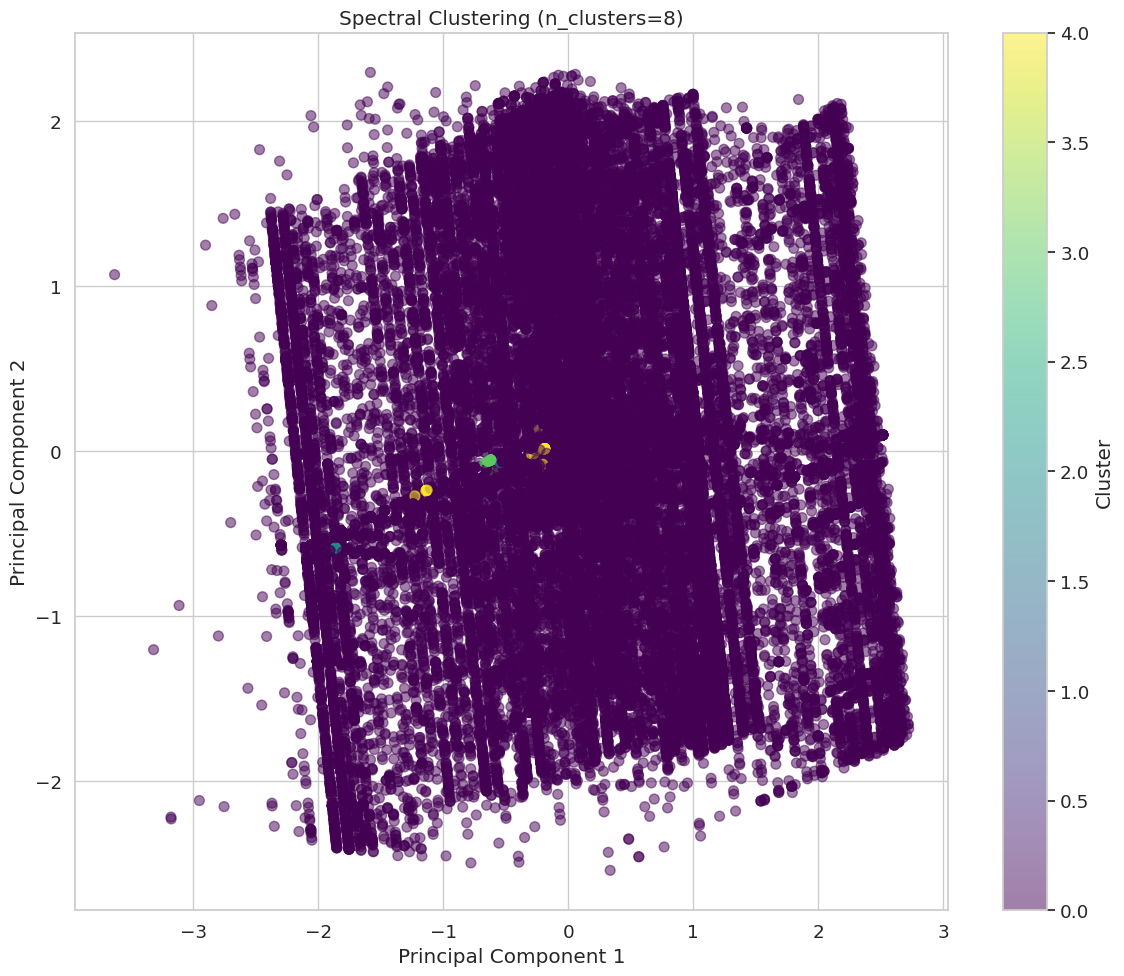

Sampling 5000 points for silhouette calculation
Silhouette score calculated in 0.95 seconds
Silhouette plot created in 0.03 seconds
Cluster visualization created in 0.02 seconds
Total execution time: 1.01 seconds


<Figure size 1000x600 with 0 Axes>

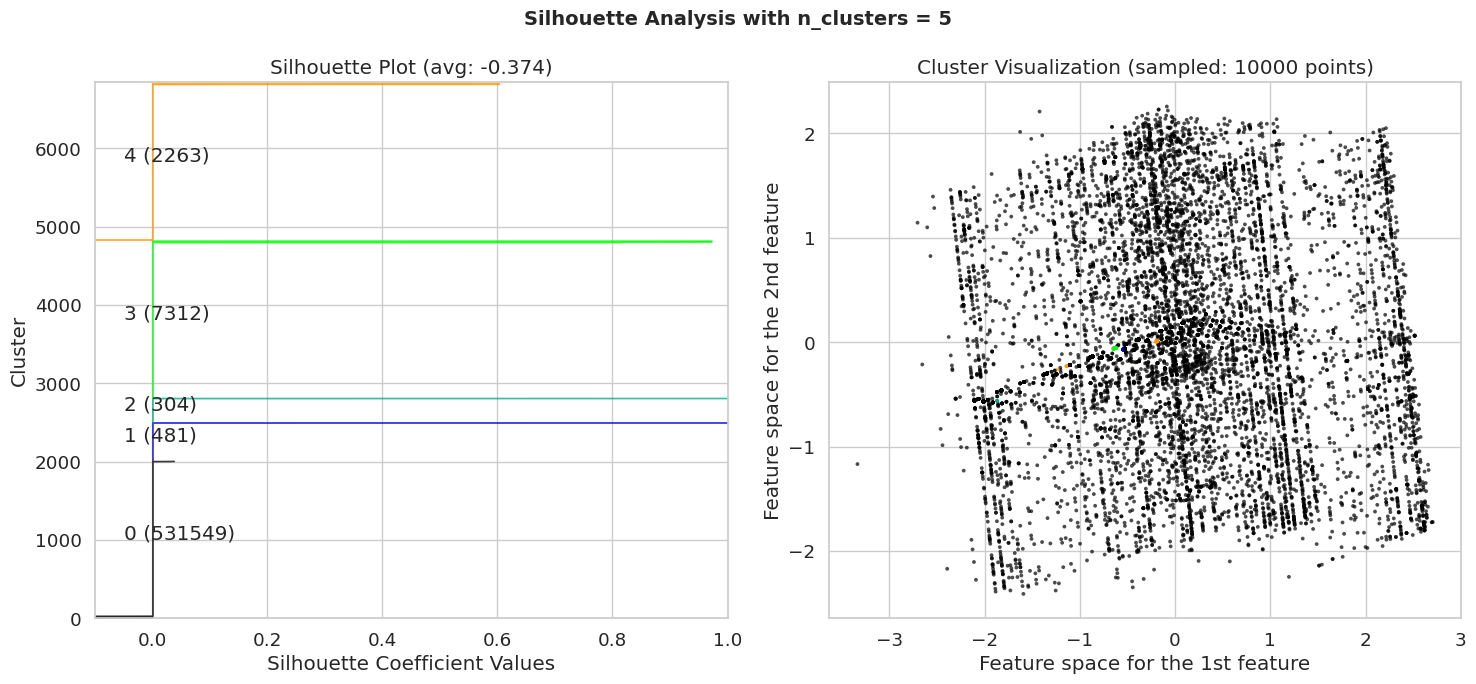

In [9]:
"""
### 4.5 Spectral Clustering
Spectral clustering is a technique that uses the eigenvalues of a similarity matrix
to reduce dimensionality before clustering in fewer dimensions. It works particularly well
for data that contains non-convex clusters.
"""

# Function to find optimal number of clusters for Spectral Clustering
# Function to find optimal number of clusters for Spectral Clustering
def find_optimal_spectral_clusters(X, max_clusters=10, sample_size=2000):
    """
    Find the optimal number of clusters for Spectral Clustering using silhouette score.
    Uses optimized parameters and smaller sample size for faster computation.

    Parameters:
    X (array-like): Input data
    max_clusters (int): Maximum number of clusters to consider
    sample_size (int): Maximum sample size to use for computation

    Returns:
    int: Optimal number of clusters
    """
    # Convert X to numpy array if it's a pandas DataFrame
    if isinstance(X, pd.DataFrame):
        X_data = X.values
    else:
        X_data = X

    # If the dataset is too large, sample it to speed up computation
    if X_data.shape[0] > sample_size:
        print(f"Sampling {sample_size} points for Spectral Clustering optimization...")
        sampled_indices = np.random.choice(range(X_data.shape[0]), size=sample_size, replace=False)
        X_sampled = X_data[sampled_indices]
    else:
        X_sampled = X_data

    print(f"Finding optimal number of clusters for Spectral Clustering (2 to {max_clusters})...")
    n_clusters_range = range(2, max_clusters + 1)
    silhouette_scores = []

    for n_clusters in n_clusters_range:
        try:
            print(f"Testing Spectral Clustering with {n_clusters} clusters...")
            spectral = SpectralClustering(
                n_clusters=n_clusters,
                affinity='nearest_neighbors',
                random_state=42,
                n_jobs=-1
            )
            labels = spectral.fit_predict(X_sampled)

            # Check if we have at least 2 unique clusters
            unique_labels = np.unique(labels)
            if len(unique_labels) > 1:
                score = silhouette_score(X_sampled, labels)
                silhouette_scores.append(score)
                print(f"Silhouette score for n_clusters={n_clusters}: {score:.4f}")
            else:
                print(f"Only one cluster found for n_clusters={n_clusters}")
                silhouette_scores.append(0)
        except Exception as e:
            print(f"Error testing Spectral Clustering with {n_clusters} clusters: {e}")
            silhouette_scores.append(0)

    # Plot silhouette scores if we have valid results
    if len(silhouette_scores) > 0 and not all(s == 0 for s in silhouette_scores):
        try:
            plt.figure(figsize=(10, 6))
            plt.plot(n_clusters_range, silhouette_scores, 'bo-')
            plt.xlabel('Number of clusters')
            plt.ylabel('Silhouette Score')
            plt.title('Silhouette Score for Spectral Clustering')
            plt.grid(True)

            # Find the optimal number of clusters
            optimal_n_clusters = n_clusters_range[np.argmax(silhouette_scores)]
            plt.axvline(x=optimal_n_clusters, color='r', linestyle='--',
                        label=f'Optimal n_clusters={optimal_n_clusters}')
            plt.legend()

            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error plotting silhouette scores: {e}")

    # Find the optimal number of clusters
    try:
        best_idx = np.argmax(silhouette_scores)
        optimal_n_clusters = n_clusters_range[best_idx]
        best_score = silhouette_scores[best_idx]
        print(f"Optimal number of clusters for Spectral Clustering: {optimal_n_clusters} (silhouette score: {best_score:.4f})")
        return optimal_n_clusters
    except Exception as e:
        print(f"Error determining optimal number of clusters: {e}")
        return 3  # Default fallback

print("Starting Spectral Clustering analysis...")

# Convert X to numpy array if it's a pandas DataFrame
if isinstance(X, pd.DataFrame):
    X_data = X.values
else:
    X_data = X

# Find the optimal number of clusters for Spectral Clustering
try:
    optimal_n_spectral = find_optimal_spectral_clusters(X_data, max_clusters=10)
except Exception as e:
    print(f"Error in finding optimal Spectral Clustering parameters: {e}")
    # Use default number of clusters if optimization fails
    optimal_n_spectral = min(3, X_data.shape[1])
    print(f"Using default number of clusters: {optimal_n_spectral}")

# Train the Spectral Clustering model with optimizations
print(f"Fitting Spectral Clustering with {optimal_n_spectral} clusters...")
start_time = time.time()

# If the dataset is very large, use a sample for spectral clustering
max_sample_size = 10000  # Maximum number of samples to use for full spectral clustering
if X_data.shape[0] > max_sample_size:
    print(f"Dataset is large ({X_data.shape[0]} samples). Using {max_sample_size} samples for spectral clustering and propagating labels.")

    # Sample data points
    sampled_indices = np.random.choice(range(X_data.shape[0]), size=max_sample_size, replace=False)
    X_sampled = X_data[sampled_indices]

    # Perform Spectral Clustering on the sample
    spectral = SpectralClustering(
        n_clusters=optimal_n_spectral,
        affinity='nearest_neighbors',  # Using nearest neighbors for better performance
        n_neighbors=10,  # Limit number of neighbors to consider for large datasets
        random_state=42,
        n_jobs=-1,  # Use all available CPU cores
        assign_labels='kmeans'  # Using k-means for final assignment (faster)
    )
    sampled_labels = spectral.fit_predict(X_sampled)

    # Propagate labels to the rest of the dataset using a KNN classifier
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    knn.fit(X_sampled, sampled_labels)
    spectral_labels = knn.predict(X_data)
else:
    # For smaller datasets, use direct spectral clustering with optimized parameters
    spectral = SpectralClustering(
        n_clusters=optimal_n_spectral,
        affinity='nearest_neighbors',
        n_neighbors=min(10, X_data.shape[0] // optimal_n_spectral),  # Adaptive n_neighbors
        random_state=42,
        n_jobs=-1,
        assign_labels='kmeans'  # Faster assignment
    )
    spectral_labels = spectral.fit_predict(X_data)

spectral_time = time.time() - start_time

print(f"Spectral Clustering completed in {spectral_time:.2f} seconds")
print(f"Number of clusters: {optimal_n_clusters}")

# Show cluster sizes
try:
    cluster_counts = pd.Series(spectral_labels).value_counts().sort_index()
    print("Cluster sizes:")
    print(cluster_counts)
except Exception as e:
    print(f"Error displaying cluster sizes: {e}")

# Visualize the Spectral Clustering results using PCA
try:
    plt.figure(figsize=(12, 10))

    # Use PCA to reduce dimensionality for visualization if needed
    if X_data.shape[1] > 2:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_data)
    else:
        X_pca = X_data

    # Sample if the dataset is very large
    if len(X_pca) > 50000:
        sample_idx = np.random.choice(len(X_pca), size=50000, replace=False)
        plt.scatter(X_pca[sample_idx, 0], X_pca[sample_idx, 1],
                   c=spectral_labels[sample_idx], cmap='viridis', alpha=0.5, s=50)
    else:
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=spectral_labels, cmap='viridis', alpha=0.5, s=50)

    plt.title(f'Spectral Clustering (n_clusters={optimal_n_clusters})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Cluster')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error in visualization: {e}")

# Visualize the silhouette plot for Spectral Clustering
plt.figure(figsize=(10, 6))
plot_silhouette(X_data, spectral_labels, optimal_n_spectral, max_points_per_cluster=2000, silhouette_sample_size=5000)
plt.show()

spectral_eval = evaluate_clustering(X_data, spectral_labels, 'Spectral Clustering', sampling_ratio=0.1)
all_evaluations.append(spectral_eval)

## 5. Evaluasi & Visualisasi

Creating clustering models comparison visualizations...

📊 Tabel Perbandingan Clustering Models:


Model  Silhouette Score  Davies-Bouldin Index  \
0  Spectral Clustering            -0.351                 2.978   
1              K-Means             0.355                 1.085   
2        Agglomerative             0.343                 0.937   
3               DBSCAN            -0.542                 1.919   
4                  GMM             0.095                 4.391   

   Calinski-Harabasz Score  Number of Clusters  Computation Time (s)  
0                   58.909                   5                  1.90  
1                28362.832                   3                  1.77  
2                30352.445                   7                  1.67  
3                  173.574                 598                  2.35  
4                10143.003                   3                  1.73


📈 Pebandingan Metrik Bar Charts:


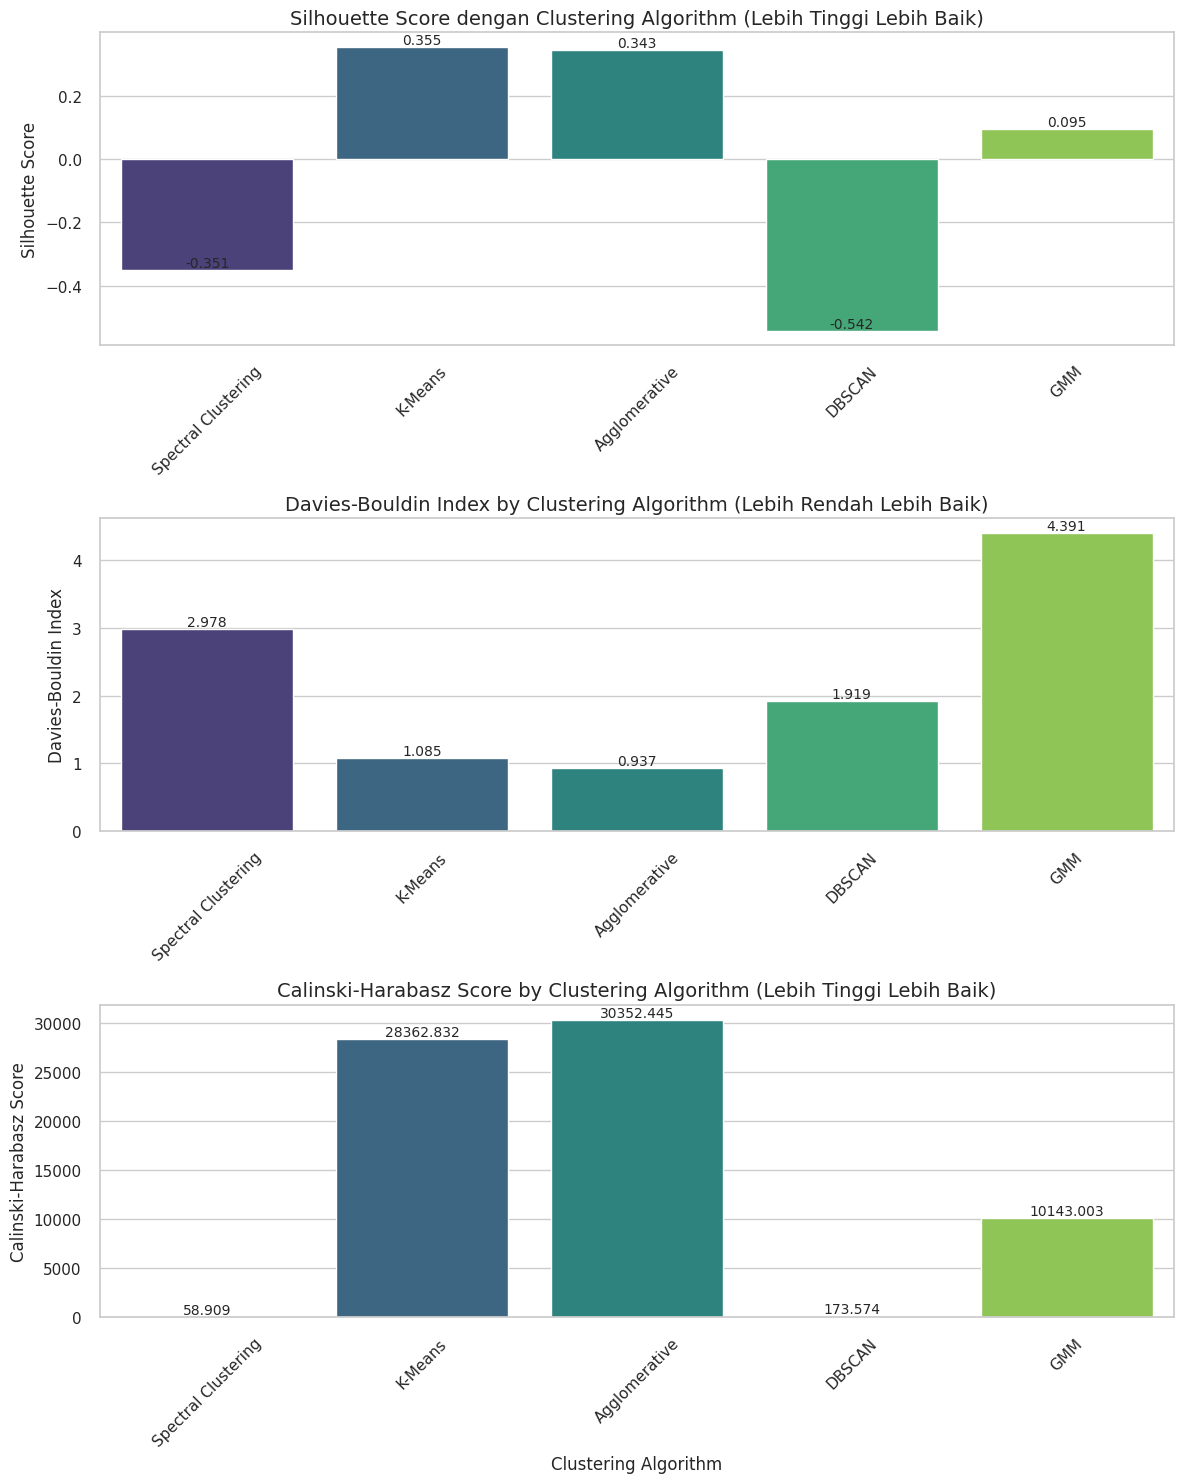


📊 Perbandingan Radar Chart (Normalized Metrics):


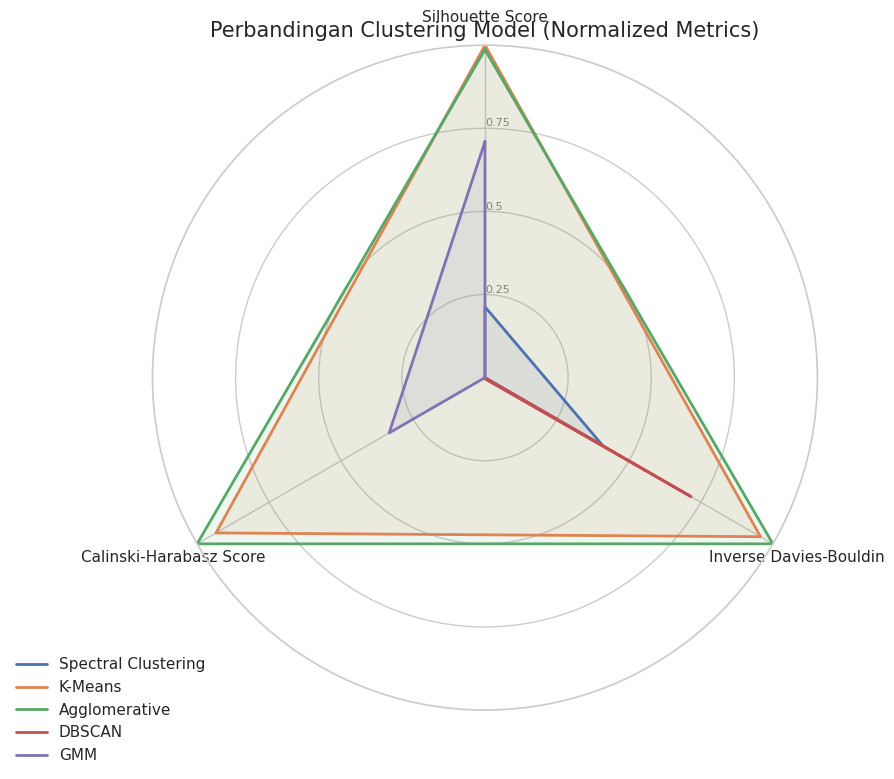


🏆 Model Terbaik:



    ## Analisis Clustering Model Terbaik
    
    ### Model Terbaik Berdasarkan Metrik Individu:
    - **Silhouette Score** (Lebih tinggi lebih baik): K-Means
    - **Davies-Bouldin Index** (Lebih rendah lebih baik): Agglomerative
    - **Calinski-Harabasz Score** (Lebih tinggi lebih baik): Agglomerative
    
    ### Model Terbaik Secara Keseluruhan: **Agglomerative**
    Model ini dipilih sebagai model dengan performa terbaik secara keseluruhan dengan 2 dari 3 votes.
    
    ### Metrik untuk Model Terbaik:
    - **Silhouette Score**: 0.343
    - **Davies-Bouldin Index**: 0.937
    - **Calinski-Harabasz Score**: 30352.445
    - **Number of Clusters**: 7
    - **Computation Time**: 1.67 seconds
    
    Algoritma **Agglomerative** menunjukkan kinerja keseluruhan terbaik di seluruh metrik evaluasi, yang menunjukkan bahwa algoritme ini menyediakan kluster yang paling koheren dan terpisah dengan baik untuk kumpulan data ini.
    

In [19]:
# 5. Evaluation & Visualization - Metrics Comparison

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import Markdown, display

def create_model_comparison_table(all_evaluations):
    """
    Create a comparative table of clustering model metrics.

    Parameters:
    -----------
    all_evaluations : list
        List of dictionaries containing evaluation metrics for clustering models.

    Returns:
    --------
    pd.DataFrame
        DataFrame containing the metrics comparison.
    """
    # Extract relevant metrics for comparison
    comparison_df = pd.DataFrame([
        {
            'Model': eval_dict['model'],
            'Silhouette Score': eval_dict['silhouette_score'],
            'Davies-Bouldin Index': eval_dict['davies_bouldin_score'],
            'Calinski-Harabasz Score': eval_dict['calinski_harabasz_score'],
            'Number of Clusters': eval_dict['num_clusters'],
            'Computation Time (s)': eval_dict['computation_time']
        }
        for eval_dict in all_evaluations
    ])

    # Format the numeric columns for better readability
    for col in ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Score']:
        comparison_df[col] = comparison_df[col].round(3)

    comparison_df['Computation Time (s)'] = comparison_df['Computation Time (s)'].round(2)

    return comparison_df

def highlight_best_model(comparison_df):
    """
    Determine the best performing model based on multiple metrics.

    Parameters:
    -----------
    comparison_df : pd.DataFrame
        DataFrame containing the metrics comparison.

    Returns:
    --------
    dict
        Dictionary with best model information and scores.
    """
    # For silhouette and calinski-harabasz, higher is better
    # For davies-bouldin, lower is better
    best_silhouette_idx = comparison_df['Silhouette Score'].idxmax()
    best_db_idx = comparison_df['Davies-Bouldin Index'].idxmin()
    best_ch_idx = comparison_df['Calinski-Harabasz Score'].idxmax()

    best_models = {
        'Silhouette Score': comparison_df.loc[best_silhouette_idx, 'Model'],
        'Davies-Bouldin Index': comparison_df.loc[best_db_idx, 'Model'],
        'Calinski-Harabasz Score': comparison_df.loc[best_ch_idx, 'Model']
    }

    # Count the "votes" for each model
    model_votes = {}
    for metric, model in best_models.items():
        if model not in model_votes:
            model_votes[model] = 0
        model_votes[model] += 1

    # Find the model with the most votes
    overall_best_model = max(model_votes.items(), key=lambda x: x[1])[0]

    # Get the scores for the overall best model
    best_model_scores = comparison_df[comparison_df['Model'] == overall_best_model].iloc[0].to_dict()

    return {
        'best_models': best_models,
        'overall_best_model': overall_best_model,
        'overall_best_model_scores': best_model_scores,
        'vote_counts': model_votes
    }

def visualize_metric_comparison(comparison_df):
    """
    Create visualizations comparing metrics across different clustering models.

    Parameters:
    -----------
    comparison_df : pd.DataFrame
        DataFrame containing the metrics comparison.
    """
    # Set style for plots
    sns.set(style="whitegrid")

    # Create a figure with 3 subplots (one for each metric)
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))

    # 1. Silhouette Score (higher is better)
    ax1 = axes[0]
    silhouette_bars = sns.barplot(x='Model', y='Silhouette Score', data=comparison_df, ax=ax1, palette='viridis')
    ax1.set_title('Silhouette Score dengan Clustering Algorithm (Lebih Tinggi Lebih Baik)', fontsize=14)
    ax1.set_xlabel('')
    ax1.set_ylabel('Silhouette Score')
    ax1.tick_params(axis='x', rotation=45)

    # Annotate the bars with values
    for p in silhouette_bars.patches:
        ax1.annotate(f'{p.get_height():.3f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10)

    # 2. Davies-Bouldin Index (lower is better)
    ax2 = axes[1]
    db_bars = sns.barplot(x='Model', y='Davies-Bouldin Index', data=comparison_df, ax=ax2, palette='viridis')
    ax2.set_title('Davies-Bouldin Index by Clustering Algorithm (Lebih Rendah Lebih Baik)', fontsize=14)
    ax2.set_xlabel('')
    ax2.set_ylabel('Davies-Bouldin Index')
    ax2.tick_params(axis='x', rotation=45)

    # Annotate the bars with values
    for p in db_bars.patches:
        ax2.annotate(f'{p.get_height():.3f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10)

    # 3. Calinski-Harabasz Score (higher is better)
    ax3 = axes[2]
    ch_bars = sns.barplot(x='Model', y='Calinski-Harabasz Score', data=comparison_df, ax=ax3, palette='viridis')
    ax3.set_title('Calinski-Harabasz Score by Clustering Algorithm (Lebih Tinggi Lebih Baik)', fontsize=14)
    ax3.set_xlabel('Clustering Algorithm')
    ax3.set_ylabel('Calinski-Harabasz Score')
    ax3.tick_params(axis='x', rotation=45)

    # Annotate the bars with values
    for p in ch_bars.patches:
        ax3.annotate(f'{p.get_height():.3f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

def create_radar_chart(comparison_df):
    """
    Create a radar chart comparing all models across normalized metrics.

    Parameters:
    -----------
    comparison_df : pd.DataFrame
        DataFrame containing the metrics comparison.
    """
    # Prepare the data for radar chart
    models = comparison_df['Model'].tolist()

    # We need to normalize the metrics to a 0-1 scale for fair comparison
    # For Silhouette and Calinski-Harabasz, higher is better, so normalize directly
    # For Davies-Bouldin, lower is better, so invert the normalization

    metrics_to_normalize = ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Score']
    normalized_df = comparison_df.copy()

    for metric in metrics_to_normalize:
        if metric == 'Davies-Bouldin Index':
            # For Davies-Bouldin, lower is better, so invert
            min_val = comparison_df[metric].min()
            max_val = comparison_df[metric].max()
            if max_val > min_val:  # Avoid division by zero
                normalized_df[f'Normalized {metric}'] = 1 - ((comparison_df[metric] - min_val) / (max_val - min_val))
            else:
                normalized_df[f'Normalized {metric}'] = 1.0
        else:
            # For other metrics, higher is better
            min_val = comparison_df[metric].min()
            max_val = comparison_df[metric].max()
            if max_val > min_val:  # Avoid division by zero
                normalized_df[f'Normalized {metric}'] = (comparison_df[metric] - min_val) / (max_val - min_val)
            else:
                normalized_df[f'Normalized {metric}'] = 1.0

    # Categories for the radar chart
    categories = ['Silhouette Score', 'Inverse Davies-Bouldin', 'Calinski-Harabasz Score']

    # Set figure size
    fig = plt.figure(figsize=(10, 8))

    # Create a polar projection
    ax = fig.add_subplot(111, polar=True)

    # Set the angles for each metric (dividing the plot into equal parts)
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    # Set the angle of the first axis
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], categories)

    # Draw the y-axis labels (0 to 1)
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=8)
    plt.ylim(0, 1)

    # Plot each model
    for i, model in enumerate(models):
        values = [
            normalized_df.loc[normalized_df['Model'] == model, 'Normalized Silhouette Score'].values[0],
            normalized_df.loc[normalized_df['Model'] == model, 'Normalized Davies-Bouldin Index'].values[0],
            normalized_df.loc[normalized_df['Model'] == model, 'Normalized Calinski-Harabasz Score'].values[0]
        ]
        values += values[:1]  # Close the loop

        # Plot the model values
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.1)

    # Add a legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.title('Perbandingan Clustering Model (Normalized Metrics)', size=15)
    plt.tight_layout()
    plt.show()

def display_best_model_summary(best_model_info):
    """
    Display a summary of the best model findings.

    Parameters:
    -----------
    best_model_info : dict
        Dictionary with best model information.
    """
    best_models = best_model_info['best_models']
    overall_best = best_model_info['overall_best_model']
    best_scores = best_model_info['overall_best_model_scores']
    vote_counts = best_model_info['vote_counts']

    # Create a styled summary using markdown
    summary_md = f"""
    ## Analisis Clustering Model Terbaik

    ### Model Terbaik Berdasarkan Metrik Individu:
    - **Silhouette Score** (Lebih tinggi lebih baik): {best_models['Silhouette Score']}
    - **Davies-Bouldin Index** (Lebih rendah lebih baik): {best_models['Davies-Bouldin Index']}
    - **Calinski-Harabasz Score** (Lebih tinggi lebih baik): {best_models['Calinski-Harabasz Score']}

    ### Model Terbaik Secara Keseluruhan: **{overall_best}**
    Model ini dipilih sebagai model dengan performa terbaik secara keseluruhan dengan {vote_counts[overall_best]} dari 3 votes.

    ### Metrik untuk Model Terbaik:
    - **Silhouette Score**: {best_scores['Silhouette Score']:.3f}
    - **Davies-Bouldin Index**: {best_scores['Davies-Bouldin Index']:.3f}
    - **Calinski-Harabasz Score**: {best_scores['Calinski-Harabasz Score']:.3f}
    - **Number of Clusters**: {best_scores['Number of Clusters']}
    - **Computation Time**: {best_scores['Computation Time (s)']:.2f} seconds

    Algoritma **{overall_best}** menunjukkan kinerja keseluruhan terbaik di seluruh metrik evaluasi, yang menunjukkan bahwa algoritme ini menyediakan kluster yang paling koheren dan terpisah dengan baik untuk kumpulan data ini.
    """

    display(Markdown(summary_md))

def create_styled_comparison_table(comparison_df, best_model_info):
    """
    Create a styled HTML table with best metrics highlighted.

    Parameters:
    -----------
    comparison_df : pd.DataFrame
        DataFrame containing the metrics comparison.
    best_model_info : dict
        Dictionary with best model information.
    """
    # Function to highlight the best value in each column
    def highlight_best(s, best_models):
        is_best = pd.Series(data=False, index=s.index)

        if s.name == 'Silhouette Score':
            is_best[s.idxmax()] = True
        elif s.name == 'Davies-Bouldin Index':
            is_best[s.idxmin()] = True
        elif s.name == 'Calinski-Harabasz Score':
            is_best[s.idxmax()] = True

        return ['background-color: #a8f0a8' if v else '' for v in is_best]

    # Apply styling to the DataFrame
    styled_df = comparison_df.style.apply(
        lambda col: highlight_best(col, best_model_info['best_models']),
        subset=['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Score']
    )

    # Highlight the overall best model row
    overall_best = best_model_info['overall_best_model']
    styled_df = styled_df.apply(
        lambda row: ['background-color: #f0e6a8' if row['Model'] == overall_best else '' for _ in row],
        axis=1
    )

    # Format numbers
    styled_df = styled_df.format({
        'Silhouette Score': '{:.3f}',
        'Davies-Bouldin Index': '{:.3f}',
        'Calinski-Harabasz Score': '{:.3f}',
        'Computation Time (s)': '{:.2f}'
    })

    # Set caption and return
    return styled_df.set_caption('Perbandingan Model Pengelompokan (Nilai terbaik disorot dengan warna hijau, Baris model terbaik secara keseluruhan disorot dengan warna kuning)')

# Main function to run all the comparison visualizations
def visualize_clustering_comparison(all_evaluations):
    """
    Create comprehensive visualizations and summaries comparing clustering models.

    Parameters:
    -----------
    all_evaluations : list
        List of dictionaries containing evaluation metrics for clustering models.
    """
    print("Creating clustering models comparison visualizations...")

    # Create the comparison DataFrame
    comparison_df = create_model_comparison_table(all_evaluations)

    # Display the basic comparison table
    print("\n📊 Tabel Perbandingan Clustering Models:")
    display(comparison_df)

    # Identify the best models
    best_model_info = highlight_best_model(comparison_df)

    # Create and display the styled comparison table
    styled_table = create_styled_comparison_table(comparison_df, best_model_info)
    display(styled_table)

    # Create bar charts for comparing metrics
    print("\n📈 Pebandingan Metrik Bar Charts:")
    visualize_metric_comparison(comparison_df)

    # Create radar chart for overall comparison
    print("\n📊 Perbandingan Radar Chart (Normalized Metrics):")
    create_radar_chart(comparison_df)

    # Display the best model summary
    print("\n🏆 Model Terbaik:")
    display_best_model_summary(best_model_info)

    return comparison_df, best_model_info

# Example usage:
# If all_evaluations list is already populated with model evaluations:
if len(all_evaluations) > 0:
    comparison_df, best_model_info = visualize_clustering_comparison(all_evaluations)
else:
    print("No clustering evaluations found in all_evaluations list.")
    print("Make sure to run your clustering models and evaluate them before using this visualization code.")

# Penjelasan Matematika dan Justifikasi Model

## Formula Metrik Evaluasi

### 1. Silhouette Score

Silhouette score mengevaluasi seberapa baik setiap titik data ditempatkan dalam cluster-nya dibandingkan dengan cluster terdekat lainnya.

Untuk setiap titik data $i$, Silhouette coefficient $s(i)$ dihitung sebagai:

$$
s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}
$$

dimana:
- $a(i)$ adalah jarak rata-rata dari titik $i$ ke semua titik lain dalam cluster yang sama
- $b(i)$ adalah jarak rata-rata minimum dari titik $i$ ke semua titik di cluster lain terdekat

Silhouette Score adalah rata-rata dari semua koefisien silhouette:

$$
\text{Silhouette} = \frac{1}{N}\sum_{i=1}^N s(i)
$$

Nilai berkisar antara -1 hingga 1, di mana:
- Nilai mendekati 1 menunjukkan bahwa sampel jauh dari cluster tetangga
- Nilai mendekati 0 menunjukkan sampel dekat dengan batas antar cluster
- Nilai negatif menunjukkan sampel mungkin ditempatkan di cluster yang salah

### 2. Davies-Bouldin Index

Davies-Bouldin Index mengevaluasi rasio antara jarak intra-cluster dan inter-cluster.

$$
DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left( \frac{\sigma_i + \sigma_j}{d(c_i, c_j)} \right)
$$


dimana:
- $k$ adalah jumlah cluster
- $\sigma_i$ adalah jarak rata-rata dari setiap titik dalam cluster $i$ ke centroid cluster-nya
- $d(c_i, c_j)$ adalah jarak antara centroid cluster $i$ dan $j$

Nilai yang lebih rendah menunjukkan cluster yang lebih terpisah dengan baik.

### 3. Calinski-Harabasz Index

Calinski-Harabasz Index, juga dikenal sebagai Variance Ratio Criterion, mengukur rasio antara dispersi antar-cluster dan dispersi intra-cluster.

$$
CH = \frac{\text{tr}(B_k) / (k-1)}{\text{tr}(W_k) / (n-k)}
$$

dimana:
- $n$ adalah jumlah titik data
- $k$ adalah jumlah cluster
- $B_k$ adalah matriks dispersi antar-cluster
- $W_k$ adalah matriks dispersi intra-cluster
- $\text{tr}()$ adalah trace matriks

Nilai yang lebih tinggi menunjukkan cluster yang lebih terpisah dengan baik.

## Penjelasan Algoritma Clustering

### 1. K-Means
K-Means adalah algoritma clustering partisional yang bertujuan untuk meminimalkan inersia (jumlah kuadrat jarak titik data ke centroid terdekat):

$$
J = \sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|^2
$$

dimana $\mu_i$ adalah centroid cluster $C_i$.

Algoritma bekerja dengan:
1. Inisialisasi $k$ centroid secara acak
2. Mengalokasikan setiap titik data ke centroid terdekat
3. Menghitung ulang centroid sebagai rata-rata dari titik dalam cluster
4. Mengulangi langkah 2-3 hingga konvergen

### 2. Agglomerative Clustering
Agglomerative Clustering adalah metode hierarchical clustering dengan pendekatan bottom-up:

1. Dimulai dengan setiap titik data sebagai cluster individual
2. Pada setiap iterasi, menggabungkan dua cluster terdekat berdasarkan kriteria linkage
3. Proses berlanjut hingga semua titik digabungkan menjadi satu cluster

Kriteria linkage umum termasuk:
- Single linkage: $d(C_i, C_j) = \min_{x \in C_i, y \in C_j} d(x, y)$
- Complete linkage: $d(C_i, C_j) = \max_{x \in C_i, y \in C_j} d(x, y)$
- Average linkage: $d(C_i, C_j) = \frac{1}{|C_i||C_j|} \sum_{x \in C_i} \sum_{y \in C_j} d(x, y)$
- Ward linkage: Meminimalkan varians dalam cluster yang digabungkan

### 3. DBSCAN
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) mengelompokkan titik berdasarkan kepadatan:

1. Titik inti: Titik dengan minimal `min_samples` tetangga dalam radius `eps`
2. Titik terhubung-langsung: Titik dalam radius `eps` dari titik inti
3. Titik terhubung-kepadatan: Titik yang dapat dicapai melalui rantai titik terhubung-langsung
4. Noise: Titik yang bukan inti dan tidak terhubung-kepadatan ke titik inti lain

DBSCAN tidak memerlukan jumlah cluster yang ditentukan sebelumnya dan dapat menemukan cluster dengan bentuk arbitrary.

### 4. Gaussian Mixture Model
GMM memodelkan data sebagai campuran distribusi Gaussian:

$$
p(x) = \sum_{i=1}^{k} \pi_i \mathcal{N}(x | \mu_i, \Sigma_i)
$$

dimana:
- $\pi_i$ adalah bobot campuran (mixing weight) untuk komponen ke-$i$
- $\mu_i$ dan $\Sigma_i$ adalah mean dan covariance dari distribusi Gaussian ke-$i$

Parameter diestimasi menggunakan algoritma Expectation-Maximization (EM):
1. E-step: Menghitung probabilitas posterior setiap titik data terhadap setiap komponen
2. M-step: Memperbarui parameter model berdasarkan probabilitas yang dihitung

### 5. Spectral Clustering
Spectral Clustering menggunakan eigenvalue dari matriks similaritas untuk mereduksi dimensi:

1. Membangun matriks similaritas/adjacency $W$ antar titik data
2. Menghitung normalized Laplacian matrix $L = I - D^{-1/2}WD^{-1/2}$ di mana $D$ adalah matriks diagonal dengan $D_{ii} = \sum_j W_{ij}$
3. Menghitung eigenvector $k$ terendah dari $L$ (kecuali eigenvector dengan eigenvalue 0)
4. Melakukan K-Means pada eigenvector tersebut

Spectral Clustering efektif untuk menemukan cluster non-convex.

